# Miller age

In [1]:
ood_seed = 12

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Lung secretory cells', '15.0'), 595)


Removed datapoint: 595

train         5433
validation    1377
ood            595
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 98314.79it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 1044731.44it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 170.30it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:02<15:32,  2.34s/it]

Epoch 1/400:   0%|          | 1/400 [00:02<15:32,  2.34s/it, v_num=1, recon=1.19e+3, r2_mean=0.0666, adv_loss=3.43, acc_pert=0.31, acc_integration_donor=0.15]

Epoch 2/400:   0%|          | 1/400 [00:02<15:32,  2.34s/it, v_num=1, recon=1.19e+3, r2_mean=0.0666, adv_loss=3.43, acc_pert=0.31, acc_integration_donor=0.15]

Epoch 2/400:   0%|          | 2/400 [00:04<14:45,  2.23s/it, v_num=1, recon=1.19e+3, r2_mean=0.0666, adv_loss=3.43, acc_pert=0.31, acc_integration_donor=0.15]

Epoch 2/400:   0%|          | 2/400 [00:04<14:45,  2.23s/it, v_num=1, recon=1e+3, r2_mean=0.31, adv_loss=3.03, acc_pert=0.431, acc_integration_donor=0.34]    

Epoch 3/400:   0%|          | 2/400 [00:04<14:45,  2.23s/it, v_num=1, recon=1e+3, r2_mean=0.31, adv_loss=3.03, acc_pert=0.431, acc_integration_donor=0.34]

Epoch 3/400:   1%|          | 3/400 [00:06<14:36,  2.21s/it, v_num=1, recon=1e+3, r2_mean=0.31, adv_loss=3.03, acc_pert=0.431, acc_integration_donor=0.34]

Epoch 3/400:   1%|          | 3/400 [00:06<14:36,  2.21s/it, v_num=1, recon=933, r2_mean=0.409, adv_loss=2.68, acc_pert=0.503, acc_integration_donor=0.457]

Epoch 4/400:   1%|          | 3/400 [00:06<14:36,  2.21s/it, v_num=1, recon=933, r2_mean=0.409, adv_loss=2.68, acc_pert=0.503, acc_integration_donor=0.457]

Epoch 4/400:   1%|          | 4/400 [00:08<14:31,  2.20s/it, v_num=1, recon=933, r2_mean=0.409, adv_loss=2.68, acc_pert=0.503, acc_integration_donor=0.457]

Epoch 4/400:   1%|          | 4/400 [00:08<14:31,  2.20s/it, v_num=1, recon=900, r2_mean=0.459, adv_loss=2.43, acc_pert=0.535, acc_integration_donor=0.515]

Epoch 5/400:   1%|          | 4/400 [00:08<14:31,  2.20s/it, v_num=1, recon=900, r2_mean=0.459, adv_loss=2.43, acc_pert=0.535, acc_integration_donor=0.515]

Epoch 5/400:   1%|▏         | 5/400 [00:11<14:28,  2.20s/it, v_num=1, recon=900, r2_mean=0.459, adv_loss=2.43, acc_pert=0.535, acc_integration_donor=0.515]

Epoch 5/400:   1%|▏         | 5/400 [00:11<14:28,  2.20s/it, v_num=1, recon=884, r2_mean=0.482, adv_loss=2.33, acc_pert=0.548, acc_integration_donor=0.531]

Epoch 6/400:   1%|▏         | 5/400 [00:11<14:28,  2.20s/it, v_num=1, recon=884, r2_mean=0.482, adv_loss=2.33, acc_pert=0.548, acc_integration_donor=0.531]

Epoch 6/400:   2%|▏         | 6/400 [00:13<14:21,  2.19s/it, v_num=1, recon=884, r2_mean=0.482, adv_loss=2.33, acc_pert=0.548, acc_integration_donor=0.531]

Epoch 6/400:   2%|▏         | 6/400 [00:13<14:21,  2.19s/it, v_num=1, recon=870, r2_mean=0.489, adv_loss=2.3, acc_pert=0.552, acc_integration_donor=0.535] 

Epoch 7/400:   2%|▏         | 6/400 [00:13<14:21,  2.19s/it, v_num=1, recon=870, r2_mean=0.489, adv_loss=2.3, acc_pert=0.552, acc_integration_donor=0.535]

Epoch 7/400:   2%|▏         | 7/400 [00:15<14:15,  2.18s/it, v_num=1, recon=870, r2_mean=0.489, adv_loss=2.3, acc_pert=0.552, acc_integration_donor=0.535]

Epoch 7/400:   2%|▏         | 7/400 [00:15<14:15,  2.18s/it, v_num=1, recon=863, r2_mean=0.492, adv_loss=2.26, acc_pert=0.557, acc_integration_donor=0.542]

Epoch 8/400:   2%|▏         | 7/400 [00:15<14:15,  2.18s/it, v_num=1, recon=863, r2_mean=0.492, adv_loss=2.26, acc_pert=0.557, acc_integration_donor=0.542]

Epoch 8/400:   2%|▏         | 8/400 [00:17<14:11,  2.17s/it, v_num=1, recon=863, r2_mean=0.492, adv_loss=2.26, acc_pert=0.557, acc_integration_donor=0.542]

Epoch 8/400:   2%|▏         | 8/400 [00:17<14:11,  2.17s/it, v_num=1, recon=856, r2_mean=0.505, adv_loss=2.22, acc_pert=0.579, acc_integration_donor=0.535]

Epoch 9/400:   2%|▏         | 8/400 [00:17<14:11,  2.17s/it, v_num=1, recon=856, r2_mean=0.505, adv_loss=2.22, acc_pert=0.579, acc_integration_donor=0.535]

Epoch 9/400:   2%|▏         | 9/400 [00:19<14:09,  2.17s/it, v_num=1, recon=856, r2_mean=0.505, adv_loss=2.22, acc_pert=0.579, acc_integration_donor=0.535]

Epoch 9/400:   2%|▏         | 9/400 [00:19<14:09,  2.17s/it, v_num=1, recon=848, r2_mean=0.506, adv_loss=2.16, acc_pert=0.589, acc_integration_donor=0.538]

Epoch 10/400:   2%|▏         | 9/400 [00:19<14:09,  2.17s/it, v_num=1, recon=848, r2_mean=0.506, adv_loss=2.16, acc_pert=0.589, acc_integration_donor=0.538]


disnt_basal = 0.5388716008742676

disnt_after = 0.9487989429259914

val_r2_mean = 0.5302203121510419

val_r2_var = 0.20396550812504508


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:23<16:54,  2.60s/it, v_num=1, recon=848, r2_mean=0.506, adv_loss=2.16, acc_pert=0.589, acc_integration_donor=0.538]

Epoch 10/400:   2%|▎         | 10/400 [00:23<16:54,  2.60s/it, v_num=1, recon=842, r2_mean=0.514, adv_loss=2.18, acc_pert=0.57, acc_integration_donor=0.533, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:23<16:54,  2.60s/it, v_num=1, recon=842, r2_mean=0.514, adv_loss=2.18, acc_pert=0.57, acc_integration_donor=0.533, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:25<15:53,  2.45s/it, v_num=1, recon=842, r2_mean=0.514, adv_loss=2.18, acc_pert=0.57, acc_integration_donor=0.533, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:25<15:53,  2.45s/it, v_num=1, recon=840, r2_mean=0.515, adv_loss=2.15, acc_pert=0.569, acc_integration_donor=0.534, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:25<15:53,  2.45s/it, v_num=1, recon=840, r2_mean=0.515, adv_loss=2.15, acc_pert=0.569, acc_integration_donor=0.534, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:27<15:14,  2.36s/it, v_num=1, recon=840, r2_mean=0.515, adv_loss=2.15, acc_pert=0.569, acc_integration_donor=0.534, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:27<15:14,  2.36s/it, v_num=1, recon=838, r2_mean=0.518, adv_loss=2.15, acc_pert=0.572, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:27<15:14,  2.36s/it, v_num=1, recon=838, r2_mean=0.518, adv_loss=2.15, acc_pert=0.572, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:29<14:45,  2.29s/it, v_num=1, recon=838, r2_mean=0.518, adv_loss=2.15, acc_pert=0.572, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:29<14:45,  2.29s/it, v_num=1, recon=834, r2_mean=0.527, adv_loss=2.15, acc_pert=0.558, acc_integration_donor=0.515, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:29<14:45,  2.29s/it, v_num=1, recon=834, r2_mean=0.527, adv_loss=2.15, acc_pert=0.558, acc_integration_donor=0.515, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:31<14:23,  2.24s/it, v_num=1, recon=834, r2_mean=0.527, adv_loss=2.15, acc_pert=0.558, acc_integration_donor=0.515, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:31<14:23,  2.24s/it, v_num=1, recon=832, r2_mean=0.529, adv_loss=2.15, acc_pert=0.554, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:31<14:23,  2.24s/it, v_num=1, recon=832, r2_mean=0.529, adv_loss=2.15, acc_pert=0.554, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:33<14:09,  2.21s/it, v_num=1, recon=832, r2_mean=0.529, adv_loss=2.15, acc_pert=0.554, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:33<14:09,  2.21s/it, v_num=1, recon=829, r2_mean=0.525, adv_loss=2.14, acc_pert=0.562, acc_integration_donor=0.515, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [00:33<14:09,  2.21s/it, v_num=1, recon=829, r2_mean=0.525, adv_loss=2.14, acc_pert=0.562, acc_integration_donor=0.515, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:36<13:59,  2.19s/it, v_num=1, recon=829, r2_mean=0.525, adv_loss=2.14, acc_pert=0.562, acc_integration_donor=0.515, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:36<13:59,  2.19s/it, v_num=1, recon=826, r2_mean=0.53, adv_loss=2.16, acc_pert=0.565, acc_integration_donor=0.511, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan] 

Epoch 17/400:   4%|▍         | 16/400 [00:36<13:59,  2.19s/it, v_num=1, recon=826, r2_mean=0.53, adv_loss=2.16, acc_pert=0.565, acc_integration_donor=0.511, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:38<13:47,  2.16s/it, v_num=1, recon=826, r2_mean=0.53, adv_loss=2.16, acc_pert=0.565, acc_integration_donor=0.511, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:38<13:47,  2.16s/it, v_num=1, recon=824, r2_mean=0.532, adv_loss=2.17, acc_pert=0.564, acc_integration_donor=0.509, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:38<13:47,  2.16s/it, v_num=1, recon=824, r2_mean=0.532, adv_loss=2.17, acc_pert=0.564, acc_integration_donor=0.509, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:40<13:42,  2.15s/it, v_num=1, recon=824, r2_mean=0.532, adv_loss=2.17, acc_pert=0.564, acc_integration_donor=0.509, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:40<13:42,  2.15s/it, v_num=1, recon=822, r2_mean=0.533, adv_loss=2.17, acc_pert=0.566, acc_integration_donor=0.514, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [00:40<13:42,  2.15s/it, v_num=1, recon=822, r2_mean=0.533, adv_loss=2.17, acc_pert=0.566, acc_integration_donor=0.514, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:42<13:38,  2.15s/it, v_num=1, recon=822, r2_mean=0.533, adv_loss=2.17, acc_pert=0.566, acc_integration_donor=0.514, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:42<13:38,  2.15s/it, v_num=1, recon=819, r2_mean=0.541, adv_loss=2.19, acc_pert=0.565, acc_integration_donor=0.506, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [00:42<13:38,  2.15s/it, v_num=1, recon=819, r2_mean=0.541, adv_loss=2.19, acc_pert=0.565, acc_integration_donor=0.506, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]


disnt_basal = 0.5339487052301825

disnt_after = 0.9259053275230819

val_r2_mean = 0.5266114622354507

val_r2_var = 0.30173665149645373


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [00:45<16:09,  2.55s/it, v_num=1, recon=819, r2_mean=0.541, adv_loss=2.19, acc_pert=0.565, acc_integration_donor=0.506, val_recon=863, disnt_basal=0.539, disnt_after=0.949, val_r2_mean=0.53, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [00:45<16:09,  2.55s/it, v_num=1, recon=818, r2_mean=0.54, adv_loss=2.23, acc_pert=0.546, acc_integration_donor=0.505, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [00:45<16:09,  2.55s/it, v_num=1, recon=818, r2_mean=0.54, adv_loss=2.23, acc_pert=0.546, acc_integration_donor=0.505, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [00:48<15:20,  2.43s/it, v_num=1, recon=818, r2_mean=0.54, adv_loss=2.23, acc_pert=0.546, acc_integration_donor=0.505, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [00:48<15:20,  2.43s/it, v_num=1, recon=817, r2_mean=0.54, adv_loss=2.22, acc_pert=0.548, acc_integration_donor=0.502, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [00:48<15:20,  2.43s/it, v_num=1, recon=817, r2_mean=0.54, adv_loss=2.22, acc_pert=0.548, acc_integration_donor=0.502, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [00:50<14:50,  2.36s/it, v_num=1, recon=817, r2_mean=0.54, adv_loss=2.22, acc_pert=0.548, acc_integration_donor=0.502, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [00:50<14:50,  2.36s/it, v_num=1, recon=815, r2_mean=0.542, adv_loss=2.22, acc_pert=0.544, acc_integration_donor=0.509, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [00:50<14:50,  2.36s/it, v_num=1, recon=815, r2_mean=0.542, adv_loss=2.22, acc_pert=0.544, acc_integration_donor=0.509, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [00:52<14:25,  2.29s/it, v_num=1, recon=815, r2_mean=0.542, adv_loss=2.22, acc_pert=0.544, acc_integration_donor=0.509, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [00:52<14:25,  2.29s/it, v_num=1, recon=813, r2_mean=0.544, adv_loss=2.23, acc_pert=0.533, acc_integration_donor=0.5, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]  

Epoch 24/400:   6%|▌         | 23/400 [00:52<14:25,  2.29s/it, v_num=1, recon=813, r2_mean=0.544, adv_loss=2.23, acc_pert=0.533, acc_integration_donor=0.5, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [00:54<14:13,  2.27s/it, v_num=1, recon=813, r2_mean=0.544, adv_loss=2.23, acc_pert=0.533, acc_integration_donor=0.5, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [00:54<14:13,  2.27s/it, v_num=1, recon=813, r2_mean=0.546, adv_loss=2.25, acc_pert=0.538, acc_integration_donor=0.507, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [00:54<14:13,  2.27s/it, v_num=1, recon=813, r2_mean=0.546, adv_loss=2.25, acc_pert=0.538, acc_integration_donor=0.507, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [00:56<14:05,  2.26s/it, v_num=1, recon=813, r2_mean=0.546, adv_loss=2.25, acc_pert=0.538, acc_integration_donor=0.507, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [00:56<14:05,  2.26s/it, v_num=1, recon=810, r2_mean=0.548, adv_loss=2.29, acc_pert=0.528, acc_integration_donor=0.495, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [00:56<14:05,  2.26s/it, v_num=1, recon=810, r2_mean=0.548, adv_loss=2.29, acc_pert=0.528, acc_integration_donor=0.495, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [00:58<13:50,  2.22s/it, v_num=1, recon=810, r2_mean=0.548, adv_loss=2.29, acc_pert=0.528, acc_integration_donor=0.495, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [00:58<13:50,  2.22s/it, v_num=1, recon=807, r2_mean=0.551, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.499, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [00:58<13:50,  2.22s/it, v_num=1, recon=807, r2_mean=0.551, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.499, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:01<13:36,  2.19s/it, v_num=1, recon=807, r2_mean=0.551, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.499, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:01<13:36,  2.19s/it, v_num=1, recon=806, r2_mean=0.552, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.497, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:01<13:36,  2.19s/it, v_num=1, recon=806, r2_mean=0.552, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.497, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:03<13:25,  2.16s/it, v_num=1, recon=806, r2_mean=0.552, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.497, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:03<13:25,  2.16s/it, v_num=1, recon=806, r2_mean=0.555, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.497, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:03<13:25,  2.16s/it, v_num=1, recon=806, r2_mean=0.555, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.497, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:05<13:26,  2.17s/it, v_num=1, recon=806, r2_mean=0.555, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.497, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:05<13:26,  2.17s/it, v_num=1, recon=805, r2_mean=0.554, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.487, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan] 

Epoch 30/400:   7%|▋         | 29/400 [01:05<13:26,  2.17s/it, v_num=1, recon=805, r2_mean=0.554, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.487, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]


disnt_basal = 0.5029461870096803

disnt_after = 0.9179267964727125

val_r2_mean = 0.5140603496269747

val_r2_var = 0.3483878008343957


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:08<16:01,  2.60s/it, v_num=1, recon=805, r2_mean=0.554, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.487, val_recon=837, disnt_basal=0.534, disnt_after=0.926, val_r2_mean=0.527, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:08<16:01,  2.60s/it, v_num=1, recon=803, r2_mean=0.56, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.498, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:08<16:01,  2.60s/it, v_num=1, recon=803, r2_mean=0.56, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.498, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:11<15:03,  2.45s/it, v_num=1, recon=803, r2_mean=0.56, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.498, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:11<15:03,  2.45s/it, v_num=1, recon=804, r2_mean=0.557, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.492, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [01:11<15:03,  2.45s/it, v_num=1, recon=804, r2_mean=0.557, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.492, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:13<14:27,  2.36s/it, v_num=1, recon=804, r2_mean=0.557, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.492, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:13<14:27,  2.36s/it, v_num=1, recon=801, r2_mean=0.557, adv_loss=2.37, acc_pert=0.486, acc_integration_donor=0.494, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [01:13<14:27,  2.36s/it, v_num=1, recon=801, r2_mean=0.557, adv_loss=2.37, acc_pert=0.486, acc_integration_donor=0.494, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:15<13:59,  2.29s/it, v_num=1, recon=801, r2_mean=0.557, adv_loss=2.37, acc_pert=0.486, acc_integration_donor=0.494, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:15<13:59,  2.29s/it, v_num=1, recon=800, r2_mean=0.559, adv_loss=2.38, acc_pert=0.481, acc_integration_donor=0.493, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [01:15<13:59,  2.29s/it, v_num=1, recon=800, r2_mean=0.559, adv_loss=2.38, acc_pert=0.481, acc_integration_donor=0.493, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:17<13:47,  2.26s/it, v_num=1, recon=800, r2_mean=0.559, adv_loss=2.38, acc_pert=0.481, acc_integration_donor=0.493, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:17<13:47,  2.26s/it, v_num=1, recon=799, r2_mean=0.557, adv_loss=2.38, acc_pert=0.477, acc_integration_donor=0.49, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan] 

Epoch 35/400:   8%|▊         | 34/400 [01:17<13:47,  2.26s/it, v_num=1, recon=799, r2_mean=0.557, adv_loss=2.38, acc_pert=0.477, acc_integration_donor=0.49, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:19<13:34,  2.23s/it, v_num=1, recon=799, r2_mean=0.557, adv_loss=2.38, acc_pert=0.477, acc_integration_donor=0.49, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:19<13:34,  2.23s/it, v_num=1, recon=796, r2_mean=0.561, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.487, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [01:19<13:34,  2.23s/it, v_num=1, recon=796, r2_mean=0.561, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.487, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:21<13:23,  2.21s/it, v_num=1, recon=796, r2_mean=0.561, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.487, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:21<13:23,  2.21s/it, v_num=1, recon=797, r2_mean=0.565, adv_loss=2.4, acc_pert=0.478, acc_integration_donor=0.483, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [01:21<13:23,  2.21s/it, v_num=1, recon=797, r2_mean=0.565, adv_loss=2.4, acc_pert=0.478, acc_integration_donor=0.483, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:23<13:11,  2.18s/it, v_num=1, recon=797, r2_mean=0.565, adv_loss=2.4, acc_pert=0.478, acc_integration_donor=0.483, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:23<13:11,  2.18s/it, v_num=1, recon=794, r2_mean=0.564, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.489, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [01:23<13:11,  2.18s/it, v_num=1, recon=794, r2_mean=0.564, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.489, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:26<13:06,  2.17s/it, v_num=1, recon=794, r2_mean=0.564, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.489, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:26<13:06,  2.17s/it, v_num=1, recon=794, r2_mean=0.564, adv_loss=2.4, acc_pert=0.486, acc_integration_donor=0.485, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [01:26<13:06,  2.17s/it, v_num=1, recon=794, r2_mean=0.564, adv_loss=2.4, acc_pert=0.486, acc_integration_donor=0.485, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:28<13:05,  2.17s/it, v_num=1, recon=794, r2_mean=0.564, adv_loss=2.4, acc_pert=0.486, acc_integration_donor=0.485, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:28<13:05,  2.17s/it, v_num=1, recon=794, r2_mean=0.565, adv_loss=2.41, acc_pert=0.49, acc_integration_donor=0.483, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [01:28<13:05,  2.17s/it, v_num=1, recon=794, r2_mean=0.565, adv_loss=2.41, acc_pert=0.49, acc_integration_donor=0.483, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]


disnt_basal = 0.49822701949924536

disnt_after = 0.9185763182700041

val_r2_mean = 0.5216247114268217

val_r2_var = 0.35719419812614267


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [01:31<15:31,  2.59s/it, v_num=1, recon=794, r2_mean=0.565, adv_loss=2.41, acc_pert=0.49, acc_integration_donor=0.483, val_recon=829, disnt_basal=0.503, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [01:31<15:31,  2.59s/it, v_num=1, recon=793, r2_mean=0.564, adv_loss=2.4, acc_pert=0.474, acc_integration_donor=0.492, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [01:31<15:31,  2.59s/it, v_num=1, recon=793, r2_mean=0.564, adv_loss=2.4, acc_pert=0.474, acc_integration_donor=0.492, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [01:34<14:49,  2.48s/it, v_num=1, recon=793, r2_mean=0.564, adv_loss=2.4, acc_pert=0.474, acc_integration_donor=0.492, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [01:34<14:49,  2.48s/it, v_num=1, recon=792, r2_mean=0.567, adv_loss=2.4, acc_pert=0.478, acc_integration_donor=0.493, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [01:34<14:49,  2.48s/it, v_num=1, recon=792, r2_mean=0.567, adv_loss=2.4, acc_pert=0.478, acc_integration_donor=0.493, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [01:36<14:21,  2.41s/it, v_num=1, recon=792, r2_mean=0.567, adv_loss=2.4, acc_pert=0.478, acc_integration_donor=0.493, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [01:36<14:21,  2.41s/it, v_num=1, recon=790, r2_mean=0.565, adv_loss=2.42, acc_pert=0.468, acc_integration_donor=0.486, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [01:36<14:21,  2.41s/it, v_num=1, recon=790, r2_mean=0.565, adv_loss=2.42, acc_pert=0.468, acc_integration_donor=0.486, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [01:38<13:51,  2.33s/it, v_num=1, recon=790, r2_mean=0.565, adv_loss=2.42, acc_pert=0.468, acc_integration_donor=0.486, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [01:38<13:51,  2.33s/it, v_num=1, recon=789, r2_mean=0.572, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.482, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [01:38<13:51,  2.33s/it, v_num=1, recon=789, r2_mean=0.572, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.482, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [01:40<13:45,  2.32s/it, v_num=1, recon=789, r2_mean=0.572, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.482, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [01:40<13:45,  2.32s/it, v_num=1, recon=788, r2_mean=0.573, adv_loss=2.43, acc_pert=0.466, acc_integration_donor=0.48, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan] 

Epoch 45/400:  11%|█         | 44/400 [01:40<13:45,  2.32s/it, v_num=1, recon=788, r2_mean=0.573, adv_loss=2.43, acc_pert=0.466, acc_integration_donor=0.48, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [01:42<13:26,  2.27s/it, v_num=1, recon=788, r2_mean=0.573, adv_loss=2.43, acc_pert=0.466, acc_integration_donor=0.48, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [01:42<13:26,  2.27s/it, v_num=1, recon=787, r2_mean=0.57, adv_loss=2.43, acc_pert=0.471, acc_integration_donor=0.486, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [01:42<13:26,  2.27s/it, v_num=1, recon=787, r2_mean=0.57, adv_loss=2.43, acc_pert=0.471, acc_integration_donor=0.486, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [01:45<13:14,  2.24s/it, v_num=1, recon=787, r2_mean=0.57, adv_loss=2.43, acc_pert=0.471, acc_integration_donor=0.486, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [01:45<13:14,  2.24s/it, v_num=1, recon=787, r2_mean=0.572, adv_loss=2.46, acc_pert=0.467, acc_integration_donor=0.476, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [01:45<13:14,  2.24s/it, v_num=1, recon=787, r2_mean=0.572, adv_loss=2.46, acc_pert=0.467, acc_integration_donor=0.476, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [01:47<13:11,  2.24s/it, v_num=1, recon=787, r2_mean=0.572, adv_loss=2.46, acc_pert=0.467, acc_integration_donor=0.476, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [01:47<13:11,  2.24s/it, v_num=1, recon=785, r2_mean=0.572, adv_loss=2.42, acc_pert=0.476, acc_integration_donor=0.484, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [01:47<13:11,  2.24s/it, v_num=1, recon=785, r2_mean=0.572, adv_loss=2.42, acc_pert=0.476, acc_integration_donor=0.484, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [01:49<12:57,  2.21s/it, v_num=1, recon=785, r2_mean=0.572, adv_loss=2.42, acc_pert=0.476, acc_integration_donor=0.484, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [01:49<12:57,  2.21s/it, v_num=1, recon=785, r2_mean=0.572, adv_loss=2.45, acc_pert=0.463, acc_integration_donor=0.475, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [01:49<12:57,  2.21s/it, v_num=1, recon=785, r2_mean=0.572, adv_loss=2.45, acc_pert=0.463, acc_integration_donor=0.475, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [01:51<12:46,  2.18s/it, v_num=1, recon=785, r2_mean=0.572, adv_loss=2.45, acc_pert=0.463, acc_integration_donor=0.475, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [01:51<12:46,  2.18s/it, v_num=1, recon=784, r2_mean=0.579, adv_loss=2.44, acc_pert=0.463, acc_integration_donor=0.48, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan] 

Epoch 50/400:  12%|█▏        | 49/400 [01:51<12:46,  2.18s/it, v_num=1, recon=784, r2_mean=0.579, adv_loss=2.44, acc_pert=0.463, acc_integration_donor=0.48, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]


disnt_basal = 0.4799330633019054

disnt_after = 0.9215584639099821

val_r2_mean = 0.5211530883203853

val_r2_var = 0.3611004955389283


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [01:55<15:07,  2.59s/it, v_num=1, recon=784, r2_mean=0.579, adv_loss=2.44, acc_pert=0.463, acc_integration_donor=0.48, val_recon=828, disnt_basal=0.498, disnt_after=0.919, val_r2_mean=0.522, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [01:55<15:07,  2.59s/it, v_num=1, recon=783, r2_mean=0.577, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.476, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan] 

Epoch 51/400:  12%|█▎        | 50/400 [01:55<15:07,  2.59s/it, v_num=1, recon=783, r2_mean=0.577, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.476, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [01:57<14:23,  2.47s/it, v_num=1, recon=783, r2_mean=0.577, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.476, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [01:57<14:23,  2.47s/it, v_num=1, recon=783, r2_mean=0.575, adv_loss=2.44, acc_pert=0.481, acc_integration_donor=0.474, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [01:57<14:23,  2.47s/it, v_num=1, recon=783, r2_mean=0.575, adv_loss=2.44, acc_pert=0.481, acc_integration_donor=0.474, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [01:59<13:48,  2.38s/it, v_num=1, recon=783, r2_mean=0.575, adv_loss=2.44, acc_pert=0.481, acc_integration_donor=0.474, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [01:59<13:48,  2.38s/it, v_num=1, recon=780, r2_mean=0.573, adv_loss=2.44, acc_pert=0.466, acc_integration_donor=0.478, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [01:59<13:48,  2.38s/it, v_num=1, recon=780, r2_mean=0.573, adv_loss=2.44, acc_pert=0.466, acc_integration_donor=0.478, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:01<13:17,  2.30s/it, v_num=1, recon=780, r2_mean=0.573, adv_loss=2.44, acc_pert=0.466, acc_integration_donor=0.478, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:01<13:17,  2.30s/it, v_num=1, recon=779, r2_mean=0.572, adv_loss=2.44, acc_pert=0.465, acc_integration_donor=0.474, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [02:01<13:17,  2.30s/it, v_num=1, recon=779, r2_mean=0.572, adv_loss=2.44, acc_pert=0.465, acc_integration_donor=0.474, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:03<13:05,  2.27s/it, v_num=1, recon=779, r2_mean=0.572, adv_loss=2.44, acc_pert=0.465, acc_integration_donor=0.474, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:03<13:05,  2.27s/it, v_num=1, recon=778, r2_mean=0.573, adv_loss=2.44, acc_pert=0.471, acc_integration_donor=0.487, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [02:03<13:05,  2.27s/it, v_num=1, recon=778, r2_mean=0.573, adv_loss=2.44, acc_pert=0.471, acc_integration_donor=0.487, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:05<12:51,  2.24s/it, v_num=1, recon=778, r2_mean=0.573, adv_loss=2.44, acc_pert=0.471, acc_integration_donor=0.487, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:05<12:51,  2.24s/it, v_num=1, recon=778, r2_mean=0.577, adv_loss=2.45, acc_pert=0.467, acc_integration_donor=0.484, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [02:05<12:51,  2.24s/it, v_num=1, recon=778, r2_mean=0.577, adv_loss=2.45, acc_pert=0.467, acc_integration_donor=0.484, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:08<12:42,  2.22s/it, v_num=1, recon=778, r2_mean=0.577, adv_loss=2.45, acc_pert=0.467, acc_integration_donor=0.484, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:08<12:42,  2.22s/it, v_num=1, recon=779, r2_mean=0.581, adv_loss=2.44, acc_pert=0.465, acc_integration_donor=0.481, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [02:08<12:42,  2.22s/it, v_num=1, recon=779, r2_mean=0.581, adv_loss=2.44, acc_pert=0.465, acc_integration_donor=0.481, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [02:10<12:35,  2.20s/it, v_num=1, recon=779, r2_mean=0.581, adv_loss=2.44, acc_pert=0.465, acc_integration_donor=0.481, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [02:10<12:35,  2.20s/it, v_num=1, recon=776, r2_mean=0.58, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.484, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan] 

Epoch 58/400:  14%|█▍        | 57/400 [02:10<12:35,  2.20s/it, v_num=1, recon=776, r2_mean=0.58, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.484, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [02:12<12:25,  2.18s/it, v_num=1, recon=776, r2_mean=0.58, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.484, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [02:12<12:25,  2.18s/it, v_num=1, recon=775, r2_mean=0.576, adv_loss=2.49, acc_pert=0.461, acc_integration_donor=0.478, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [02:12<12:25,  2.18s/it, v_num=1, recon=775, r2_mean=0.576, adv_loss=2.49, acc_pert=0.461, acc_integration_donor=0.478, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [02:14<12:16,  2.16s/it, v_num=1, recon=775, r2_mean=0.576, adv_loss=2.49, acc_pert=0.461, acc_integration_donor=0.478, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [02:14<12:16,  2.16s/it, v_num=1, recon=774, r2_mean=0.579, adv_loss=2.48, acc_pert=0.455, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [02:14<12:16,  2.16s/it, v_num=1, recon=774, r2_mean=0.579, adv_loss=2.48, acc_pert=0.455, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]


disnt_basal = 0.48642122664946574

disnt_after = 0.9173564195387324

val_r2_mean = 0.5336532762104814

val_r2_var = 0.379729188978672


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [02:18<14:32,  2.57s/it, v_num=1, recon=774, r2_mean=0.579, adv_loss=2.48, acc_pert=0.455, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.48, disnt_after=0.922, val_r2_mean=0.521, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [02:18<14:32,  2.57s/it, v_num=1, recon=773, r2_mean=0.581, adv_loss=2.48, acc_pert=0.451, acc_integration_donor=0.474, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [02:18<14:32,  2.57s/it, v_num=1, recon=773, r2_mean=0.581, adv_loss=2.48, acc_pert=0.451, acc_integration_donor=0.474, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [02:20<13:53,  2.46s/it, v_num=1, recon=773, r2_mean=0.581, adv_loss=2.48, acc_pert=0.451, acc_integration_donor=0.474, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [02:20<13:53,  2.46s/it, v_num=1, recon=772, r2_mean=0.583, adv_loss=2.51, acc_pert=0.443, acc_integration_donor=0.478, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [02:20<13:53,  2.46s/it, v_num=1, recon=772, r2_mean=0.583, adv_loss=2.51, acc_pert=0.443, acc_integration_donor=0.478, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [02:22<13:26,  2.39s/it, v_num=1, recon=772, r2_mean=0.583, adv_loss=2.51, acc_pert=0.443, acc_integration_donor=0.478, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [02:22<13:26,  2.39s/it, v_num=1, recon=772, r2_mean=0.584, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.484, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan] 

Epoch 63/400:  16%|█▌        | 62/400 [02:22<13:26,  2.39s/it, v_num=1, recon=772, r2_mean=0.584, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.484, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [02:24<13:08,  2.34s/it, v_num=1, recon=772, r2_mean=0.584, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.484, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [02:24<13:08,  2.34s/it, v_num=1, recon=771, r2_mean=0.583, adv_loss=2.49, acc_pert=0.453, acc_integration_donor=0.473, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [02:24<13:08,  2.34s/it, v_num=1, recon=771, r2_mean=0.583, adv_loss=2.49, acc_pert=0.453, acc_integration_donor=0.473, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [02:26<12:54,  2.31s/it, v_num=1, recon=771, r2_mean=0.583, adv_loss=2.49, acc_pert=0.453, acc_integration_donor=0.473, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [02:26<12:54,  2.31s/it, v_num=1, recon=770, r2_mean=0.587, adv_loss=2.49, acc_pert=0.465, acc_integration_donor=0.476, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [02:26<12:54,  2.31s/it, v_num=1, recon=770, r2_mean=0.587, adv_loss=2.49, acc_pert=0.465, acc_integration_donor=0.476, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [02:29<12:37,  2.26s/it, v_num=1, recon=770, r2_mean=0.587, adv_loss=2.49, acc_pert=0.465, acc_integration_donor=0.476, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [02:29<12:37,  2.26s/it, v_num=1, recon=769, r2_mean=0.587, adv_loss=2.5, acc_pert=0.464, acc_integration_donor=0.473, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan] 

Epoch 66/400:  16%|█▋        | 65/400 [02:29<12:37,  2.26s/it, v_num=1, recon=769, r2_mean=0.587, adv_loss=2.5, acc_pert=0.464, acc_integration_donor=0.473, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [02:31<12:23,  2.23s/it, v_num=1, recon=769, r2_mean=0.587, adv_loss=2.5, acc_pert=0.464, acc_integration_donor=0.473, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [02:31<12:23,  2.23s/it, v_num=1, recon=768, r2_mean=0.589, adv_loss=2.52, acc_pert=0.458, acc_integration_donor=0.466, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [02:31<12:23,  2.23s/it, v_num=1, recon=768, r2_mean=0.589, adv_loss=2.52, acc_pert=0.458, acc_integration_donor=0.466, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [02:33<12:18,  2.22s/it, v_num=1, recon=768, r2_mean=0.589, adv_loss=2.52, acc_pert=0.458, acc_integration_donor=0.466, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [02:33<12:18,  2.22s/it, v_num=1, recon=767, r2_mean=0.588, adv_loss=2.51, acc_pert=0.453, acc_integration_donor=0.476, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [02:33<12:18,  2.22s/it, v_num=1, recon=767, r2_mean=0.588, adv_loss=2.51, acc_pert=0.453, acc_integration_donor=0.476, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [02:35<12:09,  2.20s/it, v_num=1, recon=767, r2_mean=0.588, adv_loss=2.51, acc_pert=0.453, acc_integration_donor=0.476, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [02:35<12:09,  2.20s/it, v_num=1, recon=767, r2_mean=0.586, adv_loss=2.52, acc_pert=0.441, acc_integration_donor=0.471, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [02:35<12:09,  2.20s/it, v_num=1, recon=767, r2_mean=0.586, adv_loss=2.52, acc_pert=0.441, acc_integration_donor=0.471, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [02:37<12:06,  2.19s/it, v_num=1, recon=767, r2_mean=0.586, adv_loss=2.52, acc_pert=0.441, acc_integration_donor=0.471, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [02:37<12:06,  2.19s/it, v_num=1, recon=765, r2_mean=0.587, adv_loss=2.51, acc_pert=0.441, acc_integration_donor=0.471, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [02:37<12:06,  2.19s/it, v_num=1, recon=765, r2_mean=0.587, adv_loss=2.51, acc_pert=0.441, acc_integration_donor=0.471, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]


disnt_basal = 0.46844203836277054

disnt_after = 0.9185376496305011

val_r2_mean = 0.526104371656071

val_r2_var = 0.3866977921941064


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [02:41<14:22,  2.61s/it, v_num=1, recon=765, r2_mean=0.587, adv_loss=2.51, acc_pert=0.441, acc_integration_donor=0.471, val_recon=824, disnt_basal=0.486, disnt_after=0.917, val_r2_mean=0.534, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [02:41<14:22,  2.61s/it, v_num=1, recon=764, r2_mean=0.592, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.472, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [02:41<14:22,  2.61s/it, v_num=1, recon=764, r2_mean=0.592, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.472, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [02:43<13:29,  2.46s/it, v_num=1, recon=764, r2_mean=0.592, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.472, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [02:43<13:29,  2.46s/it, v_num=1, recon=765, r2_mean=0.586, adv_loss=2.53, acc_pert=0.435, acc_integration_donor=0.466, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [02:43<13:29,  2.46s/it, v_num=1, recon=765, r2_mean=0.586, adv_loss=2.53, acc_pert=0.435, acc_integration_donor=0.466, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [02:45<12:50,  2.35s/it, v_num=1, recon=765, r2_mean=0.586, adv_loss=2.53, acc_pert=0.435, acc_integration_donor=0.466, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [02:45<12:50,  2.35s/it, v_num=1, recon=762, r2_mean=0.591, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.473, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan] 

Epoch 73/400:  18%|█▊        | 72/400 [02:45<12:50,  2.35s/it, v_num=1, recon=762, r2_mean=0.591, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.473, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [02:47<12:27,  2.28s/it, v_num=1, recon=762, r2_mean=0.591, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.473, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [02:47<12:27,  2.28s/it, v_num=1, recon=761, r2_mean=0.59, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.468, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [02:47<12:27,  2.28s/it, v_num=1, recon=761, r2_mean=0.59, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.468, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [02:49<12:23,  2.28s/it, v_num=1, recon=761, r2_mean=0.59, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.468, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [02:49<12:23,  2.28s/it, v_num=1, recon=761, r2_mean=0.59, adv_loss=2.51, acc_pert=0.449, acc_integration_donor=0.477, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [02:49<12:23,  2.28s/it, v_num=1, recon=761, r2_mean=0.59, adv_loss=2.51, acc_pert=0.449, acc_integration_donor=0.477, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [02:52<12:12,  2.25s/it, v_num=1, recon=761, r2_mean=0.59, adv_loss=2.51, acc_pert=0.449, acc_integration_donor=0.477, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [02:52<12:12,  2.25s/it, v_num=1, recon=760, r2_mean=0.592, adv_loss=2.51, acc_pert=0.45, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [02:52<12:12,  2.25s/it, v_num=1, recon=760, r2_mean=0.592, adv_loss=2.51, acc_pert=0.45, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [02:54<11:59,  2.22s/it, v_num=1, recon=760, r2_mean=0.592, adv_loss=2.51, acc_pert=0.45, acc_integration_donor=0.479, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [02:54<11:59,  2.22s/it, v_num=1, recon=760, r2_mean=0.592, adv_loss=2.54, acc_pert=0.42, acc_integration_donor=0.471, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [02:54<11:59,  2.22s/it, v_num=1, recon=760, r2_mean=0.592, adv_loss=2.54, acc_pert=0.42, acc_integration_donor=0.471, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [02:56<11:50,  2.20s/it, v_num=1, recon=760, r2_mean=0.592, adv_loss=2.54, acc_pert=0.42, acc_integration_donor=0.471, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [02:56<11:50,  2.20s/it, v_num=1, recon=759, r2_mean=0.586, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.468, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [02:56<11:50,  2.20s/it, v_num=1, recon=759, r2_mean=0.586, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.468, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [02:58<11:50,  2.21s/it, v_num=1, recon=759, r2_mean=0.586, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.468, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [02:58<11:50,  2.21s/it, v_num=1, recon=759, r2_mean=0.593, adv_loss=2.5, acc_pert=0.448, acc_integration_donor=0.471, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan] 

Epoch 79/400:  20%|█▉        | 78/400 [02:58<11:50,  2.21s/it, v_num=1, recon=759, r2_mean=0.593, adv_loss=2.5, acc_pert=0.448, acc_integration_donor=0.471, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [03:00<11:44,  2.19s/it, v_num=1, recon=759, r2_mean=0.593, adv_loss=2.5, acc_pert=0.448, acc_integration_donor=0.471, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [03:00<11:44,  2.19s/it, v_num=1, recon=758, r2_mean=0.594, adv_loss=2.51, acc_pert=0.44, acc_integration_donor=0.48, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan] 

Epoch 80/400:  20%|█▉        | 79/400 [03:00<11:44,  2.19s/it, v_num=1, recon=758, r2_mean=0.594, adv_loss=2.51, acc_pert=0.44, acc_integration_donor=0.48, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]


disnt_basal = 0.4610343155570881

disnt_after = 0.9220498913111009

val_r2_mean = 0.5270766466856003

val_r2_var = 0.39206902344118466


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [03:04<13:50,  2.59s/it, v_num=1, recon=758, r2_mean=0.594, adv_loss=2.51, acc_pert=0.44, acc_integration_donor=0.48, val_recon=823, disnt_basal=0.468, disnt_after=0.919, val_r2_mean=0.526, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [03:04<13:50,  2.59s/it, v_num=1, recon=758, r2_mean=0.591, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.474, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [03:04<13:50,  2.59s/it, v_num=1, recon=758, r2_mean=0.591, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.474, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [03:06<13:08,  2.47s/it, v_num=1, recon=758, r2_mean=0.591, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.474, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [03:06<13:08,  2.47s/it, v_num=1, recon=756, r2_mean=0.595, adv_loss=2.52, acc_pert=0.437, acc_integration_donor=0.469, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [03:06<13:08,  2.47s/it, v_num=1, recon=756, r2_mean=0.595, adv_loss=2.52, acc_pert=0.437, acc_integration_donor=0.469, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [03:08<12:40,  2.39s/it, v_num=1, recon=756, r2_mean=0.595, adv_loss=2.52, acc_pert=0.437, acc_integration_donor=0.469, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [03:08<12:40,  2.39s/it, v_num=1, recon=755, r2_mean=0.593, adv_loss=2.51, acc_pert=0.44, acc_integration_donor=0.471, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan] 

Epoch 83/400:  20%|██        | 82/400 [03:08<12:40,  2.39s/it, v_num=1, recon=755, r2_mean=0.593, adv_loss=2.51, acc_pert=0.44, acc_integration_donor=0.471, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [03:10<12:15,  2.32s/it, v_num=1, recon=755, r2_mean=0.593, adv_loss=2.51, acc_pert=0.44, acc_integration_donor=0.471, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [03:10<12:15,  2.32s/it, v_num=1, recon=754, r2_mean=0.596, adv_loss=2.54, acc_pert=0.431, acc_integration_donor=0.472, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [03:10<12:15,  2.32s/it, v_num=1, recon=754, r2_mean=0.596, adv_loss=2.54, acc_pert=0.431, acc_integration_donor=0.472, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [03:13<12:03,  2.29s/it, v_num=1, recon=754, r2_mean=0.596, adv_loss=2.54, acc_pert=0.431, acc_integration_donor=0.472, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [03:13<12:03,  2.29s/it, v_num=1, recon=752, r2_mean=0.595, adv_loss=2.53, acc_pert=0.447, acc_integration_donor=0.468, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [03:13<12:03,  2.29s/it, v_num=1, recon=752, r2_mean=0.595, adv_loss=2.53, acc_pert=0.447, acc_integration_donor=0.468, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [03:15<11:49,  2.25s/it, v_num=1, recon=752, r2_mean=0.595, adv_loss=2.53, acc_pert=0.447, acc_integration_donor=0.468, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [03:15<11:49,  2.25s/it, v_num=1, recon=753, r2_mean=0.596, adv_loss=2.52, acc_pert=0.448, acc_integration_donor=0.472, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [03:15<11:49,  2.25s/it, v_num=1, recon=753, r2_mean=0.596, adv_loss=2.52, acc_pert=0.448, acc_integration_donor=0.472, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [03:17<11:36,  2.22s/it, v_num=1, recon=753, r2_mean=0.596, adv_loss=2.52, acc_pert=0.448, acc_integration_donor=0.472, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [03:17<11:36,  2.22s/it, v_num=1, recon=752, r2_mean=0.599, adv_loss=2.52, acc_pert=0.445, acc_integration_donor=0.476, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [03:17<11:36,  2.22s/it, v_num=1, recon=752, r2_mean=0.599, adv_loss=2.52, acc_pert=0.445, acc_integration_donor=0.476, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [03:19<11:29,  2.20s/it, v_num=1, recon=752, r2_mean=0.599, adv_loss=2.52, acc_pert=0.445, acc_integration_donor=0.476, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [03:19<11:29,  2.20s/it, v_num=1, recon=751, r2_mean=0.597, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.467, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan] 

Epoch 88/400:  22%|██▏       | 87/400 [03:19<11:29,  2.20s/it, v_num=1, recon=751, r2_mean=0.597, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.467, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [03:21<11:35,  2.23s/it, v_num=1, recon=751, r2_mean=0.597, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.467, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [03:21<11:35,  2.23s/it, v_num=1, recon=750, r2_mean=0.598, adv_loss=2.52, acc_pert=0.437, acc_integration_donor=0.474, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [03:21<11:35,  2.23s/it, v_num=1, recon=750, r2_mean=0.598, adv_loss=2.52, acc_pert=0.437, acc_integration_donor=0.474, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [03:24<11:34,  2.23s/it, v_num=1, recon=750, r2_mean=0.598, adv_loss=2.52, acc_pert=0.437, acc_integration_donor=0.474, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [03:24<11:34,  2.23s/it, v_num=1, recon=751, r2_mean=0.598, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.466, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [03:24<11:34,  2.23s/it, v_num=1, recon=751, r2_mean=0.598, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.466, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]


disnt_basal = 0.46287568372845234

disnt_after = 0.9411204884301843

val_r2_mean = 0.5141995373097333

val_r2_var = 0.3946756280281327


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [03:27<13:37,  2.64s/it, v_num=1, recon=751, r2_mean=0.598, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.466, val_recon=825, disnt_basal=0.461, disnt_after=0.922, val_r2_mean=0.527, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [03:27<13:37,  2.64s/it, v_num=1, recon=749, r2_mean=0.603, adv_loss=2.54, acc_pert=0.433, acc_integration_donor=0.471, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [03:27<13:37,  2.64s/it, v_num=1, recon=749, r2_mean=0.603, adv_loss=2.54, acc_pert=0.433, acc_integration_donor=0.471, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [03:29<12:56,  2.51s/it, v_num=1, recon=749, r2_mean=0.603, adv_loss=2.54, acc_pert=0.433, acc_integration_donor=0.471, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [03:29<12:56,  2.51s/it, v_num=1, recon=748, r2_mean=0.595, adv_loss=2.53, acc_pert=0.453, acc_integration_donor=0.471, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [03:29<12:56,  2.51s/it, v_num=1, recon=748, r2_mean=0.595, adv_loss=2.53, acc_pert=0.453, acc_integration_donor=0.471, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [03:32<12:20,  2.40s/it, v_num=1, recon=748, r2_mean=0.595, adv_loss=2.53, acc_pert=0.453, acc_integration_donor=0.471, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [03:32<12:20,  2.40s/it, v_num=1, recon=746, r2_mean=0.603, adv_loss=2.51, acc_pert=0.451, acc_integration_donor=0.478, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [03:32<12:20,  2.40s/it, v_num=1, recon=746, r2_mean=0.603, adv_loss=2.51, acc_pert=0.451, acc_integration_donor=0.478, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [03:34<11:56,  2.33s/it, v_num=1, recon=746, r2_mean=0.603, adv_loss=2.51, acc_pert=0.451, acc_integration_donor=0.478, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [03:34<11:56,  2.33s/it, v_num=1, recon=746, r2_mean=0.598, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.468, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan] 

Epoch 94/400:  23%|██▎       | 93/400 [03:34<11:56,  2.33s/it, v_num=1, recon=746, r2_mean=0.598, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.468, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [03:36<11:40,  2.29s/it, v_num=1, recon=746, r2_mean=0.598, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.468, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [03:36<11:40,  2.29s/it, v_num=1, recon=745, r2_mean=0.602, adv_loss=2.52, acc_pert=0.44, acc_integration_donor=0.473, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [03:36<11:40,  2.29s/it, v_num=1, recon=745, r2_mean=0.602, adv_loss=2.52, acc_pert=0.44, acc_integration_donor=0.473, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [03:38<11:30,  2.26s/it, v_num=1, recon=745, r2_mean=0.602, adv_loss=2.52, acc_pert=0.44, acc_integration_donor=0.473, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [03:38<11:30,  2.26s/it, v_num=1, recon=744, r2_mean=0.602, adv_loss=2.52, acc_pert=0.447, acc_integration_donor=0.465, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [03:38<11:30,  2.26s/it, v_num=1, recon=744, r2_mean=0.602, adv_loss=2.52, acc_pert=0.447, acc_integration_donor=0.465, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [03:40<11:18,  2.23s/it, v_num=1, recon=744, r2_mean=0.602, adv_loss=2.52, acc_pert=0.447, acc_integration_donor=0.465, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [03:40<11:18,  2.23s/it, v_num=1, recon=743, r2_mean=0.6, adv_loss=2.52, acc_pert=0.445, acc_integration_donor=0.474, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]  

Epoch 97/400:  24%|██▍       | 96/400 [03:40<11:18,  2.23s/it, v_num=1, recon=743, r2_mean=0.6, adv_loss=2.52, acc_pert=0.445, acc_integration_donor=0.474, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [03:42<11:06,  2.20s/it, v_num=1, recon=743, r2_mean=0.6, adv_loss=2.52, acc_pert=0.445, acc_integration_donor=0.474, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [03:42<11:06,  2.20s/it, v_num=1, recon=743, r2_mean=0.601, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.473, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [03:42<11:06,  2.20s/it, v_num=1, recon=743, r2_mean=0.601, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.473, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [03:45<10:58,  2.18s/it, v_num=1, recon=743, r2_mean=0.601, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.473, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [03:45<10:58,  2.18s/it, v_num=1, recon=740, r2_mean=0.603, adv_loss=2.53, acc_pert=0.447, acc_integration_donor=0.478, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [03:45<10:58,  2.18s/it, v_num=1, recon=740, r2_mean=0.603, adv_loss=2.53, acc_pert=0.447, acc_integration_donor=0.478, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [03:47<10:55,  2.18s/it, v_num=1, recon=740, r2_mean=0.603, adv_loss=2.53, acc_pert=0.447, acc_integration_donor=0.478, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [03:47<10:55,  2.18s/it, v_num=1, recon=742, r2_mean=0.607, adv_loss=2.51, acc_pert=0.456, acc_integration_donor=0.473, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [03:47<10:55,  2.18s/it, v_num=1, recon=742, r2_mean=0.607, adv_loss=2.51, acc_pert=0.456, acc_integration_donor=0.473, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]


disnt_basal = 0.46244491228043555

disnt_after = 0.9191940566945818

val_r2_mean = 0.5160902487960729

val_r2_var = 0.39837777614593506

Epoch 100/400:  25%|██▌       | 100/400 [03:50<12:52,  2.58s/it, v_num=1, recon=742, r2_mean=0.607, adv_loss=2.51, acc_pert=0.456, acc_integration_donor=0.473, val_recon=825, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.514, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [03:50<12:52,  2.58s/it, v_num=1, recon=740, r2_mean=0.605, adv_loss=2.53, acc_pert=0.442, acc_integration_donor=0.472, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [03:50<12:52,  2.58s/it, v_num=1, recon=740, r2_mean=0.605, adv_loss=2.53, acc_pert=0.442, acc_integration_donor=0.472, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [03:52<12:12,  2.45s/it, v_num=1, recon=740, r2_mean=0.605, adv_loss=2.53, acc_pert=0.442, acc_integration_donor=0.472, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [03:52<12:12,  2.45s/it, v_num=1, recon=739, r2_mean=0.605, adv_loss=2.54, acc_pert=0.446, acc_integration_donor=0.466, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [03:52<12:12,  2.45s/it, v_num=1, recon=739, r2_mean=0.605, adv_loss=2.54, acc_pert=0.446, acc_integration_donor=0.466, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [03:55<11:46,  2.37s/it, v_num=1, recon=739, r2_mean=0.605, adv_loss=2.54, acc_pert=0.446, acc_integration_donor=0.466, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [03:55<11:46,  2.37s/it, v_num=1, recon=739, r2_mean=0.602, adv_loss=2.53, acc_pert=0.449, acc_integration_donor=0.465, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [03:55<11:46,  2.37s/it, v_num=1, recon=739, r2_mean=0.602, adv_loss=2.53, acc_pert=0.449, acc_integration_donor=0.465, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [03:57<11:22,  2.30s/it, v_num=1, recon=739, r2_mean=0.602, adv_loss=2.53, acc_pert=0.449, acc_integration_donor=0.465, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [03:57<11:22,  2.30s/it, v_num=1, recon=737, r2_mean=0.604, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.47, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan] 

Epoch 104/400:  26%|██▌       | 103/400 [03:57<11:22,  2.30s/it, v_num=1, recon=737, r2_mean=0.604, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.47, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [03:59<11:05,  2.25s/it, v_num=1, recon=737, r2_mean=0.604, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.47, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [03:59<11:05,  2.25s/it, v_num=1, recon=736, r2_mean=0.608, adv_loss=2.5, acc_pert=0.451, acc_integration_donor=0.474, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [03:59<11:05,  2.25s/it, v_num=1, recon=736, r2_mean=0.608, adv_loss=2.5, acc_pert=0.451, acc_integration_donor=0.474, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [04:01<10:59,  2.24s/it, v_num=1, recon=736, r2_mean=0.608, adv_loss=2.5, acc_pert=0.451, acc_integration_donor=0.474, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [04:01<10:59,  2.24s/it, v_num=1, recon=735, r2_mean=0.606, adv_loss=2.52, acc_pert=0.46, acc_integration_donor=0.47, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan] 

Epoch 106/400:  26%|██▋       | 105/400 [04:01<10:59,  2.24s/it, v_num=1, recon=735, r2_mean=0.606, adv_loss=2.52, acc_pert=0.46, acc_integration_donor=0.47, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [04:03<10:50,  2.21s/it, v_num=1, recon=735, r2_mean=0.606, adv_loss=2.52, acc_pert=0.46, acc_integration_donor=0.47, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [04:03<10:50,  2.21s/it, v_num=1, recon=736, r2_mean=0.607, adv_loss=2.51, acc_pert=0.453, acc_integration_donor=0.473, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [04:03<10:50,  2.21s/it, v_num=1, recon=736, r2_mean=0.607, adv_loss=2.51, acc_pert=0.453, acc_integration_donor=0.473, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [04:05<10:40,  2.19s/it, v_num=1, recon=736, r2_mean=0.607, adv_loss=2.51, acc_pert=0.453, acc_integration_donor=0.473, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [04:05<10:40,  2.19s/it, v_num=1, recon=735, r2_mean=0.61, adv_loss=2.52, acc_pert=0.447, acc_integration_donor=0.473, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan] 

Epoch 108/400:  27%|██▋       | 107/400 [04:05<10:40,  2.19s/it, v_num=1, recon=735, r2_mean=0.61, adv_loss=2.52, acc_pert=0.447, acc_integration_donor=0.473, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [04:07<10:35,  2.18s/it, v_num=1, recon=735, r2_mean=0.61, adv_loss=2.52, acc_pert=0.447, acc_integration_donor=0.473, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [04:07<10:35,  2.18s/it, v_num=1, recon=733, r2_mean=0.61, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.472, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [04:08<10:35,  2.18s/it, v_num=1, recon=733, r2_mean=0.61, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.472, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [04:10<10:29,  2.16s/it, v_num=1, recon=733, r2_mean=0.61, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.472, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [04:10<10:29,  2.16s/it, v_num=1, recon=732, r2_mean=0.614, adv_loss=2.51, acc_pert=0.451, acc_integration_donor=0.47, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [04:10<10:29,  2.16s/it, v_num=1, recon=732, r2_mean=0.614, adv_loss=2.51, acc_pert=0.451, acc_integration_donor=0.47, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]


disnt_basal = 0.4604433769225135

disnt_after = 0.9198776166965371

val_r2_mean = 0.5156496851281687

val_r2_var = 0.40203345160592685

Epoch 110/400:  28%|██▊       | 110/400 [04:13<12:17,  2.54s/it, v_num=1, recon=732, r2_mean=0.614, adv_loss=2.51, acc_pert=0.451, acc_integration_donor=0.47, val_recon=826, disnt_basal=0.462, disnt_after=0.919, val_r2_mean=0.516, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [04:13<12:17,  2.54s/it, v_num=1, recon=733, r2_mean=0.61, adv_loss=2.52, acc_pert=0.453, acc_integration_donor=0.469, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]  

Epoch 111/400:  28%|██▊       | 110/400 [04:13<12:17,  2.54s/it, v_num=1, recon=733, r2_mean=0.61, adv_loss=2.52, acc_pert=0.453, acc_integration_donor=0.469, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [04:15<11:39,  2.42s/it, v_num=1, recon=733, r2_mean=0.61, adv_loss=2.52, acc_pert=0.453, acc_integration_donor=0.469, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [04:15<11:39,  2.42s/it, v_num=1, recon=731, r2_mean=0.61, adv_loss=2.51, acc_pert=0.444, acc_integration_donor=0.477, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [04:15<11:39,  2.42s/it, v_num=1, recon=731, r2_mean=0.61, adv_loss=2.51, acc_pert=0.444, acc_integration_donor=0.477, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [04:17<11:12,  2.33s/it, v_num=1, recon=731, r2_mean=0.61, adv_loss=2.51, acc_pert=0.444, acc_integration_donor=0.477, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [04:17<11:12,  2.33s/it, v_num=1, recon=729, r2_mean=0.612, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.468, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [04:17<11:12,  2.33s/it, v_num=1, recon=729, r2_mean=0.612, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.468, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [04:20<10:56,  2.29s/it, v_num=1, recon=729, r2_mean=0.612, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.468, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [04:20<10:56,  2.29s/it, v_num=1, recon=730, r2_mean=0.612, adv_loss=2.52, acc_pert=0.452, acc_integration_donor=0.475, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [04:20<10:56,  2.29s/it, v_num=1, recon=730, r2_mean=0.612, adv_loss=2.52, acc_pert=0.452, acc_integration_donor=0.475, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [04:22<10:40,  2.24s/it, v_num=1, recon=730, r2_mean=0.612, adv_loss=2.52, acc_pert=0.452, acc_integration_donor=0.475, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [04:22<10:40,  2.24s/it, v_num=1, recon=729, r2_mean=0.61, adv_loss=2.52, acc_pert=0.436, acc_integration_donor=0.468, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan] 

Epoch 115/400:  28%|██▊       | 114/400 [04:22<10:40,  2.24s/it, v_num=1, recon=729, r2_mean=0.61, adv_loss=2.52, acc_pert=0.436, acc_integration_donor=0.468, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [04:24<10:31,  2.21s/it, v_num=1, recon=729, r2_mean=0.61, adv_loss=2.52, acc_pert=0.436, acc_integration_donor=0.468, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [04:24<10:31,  2.21s/it, v_num=1, recon=728, r2_mean=0.609, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.468, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [04:24<10:31,  2.21s/it, v_num=1, recon=728, r2_mean=0.609, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.468, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [04:26<10:27,  2.21s/it, v_num=1, recon=728, r2_mean=0.609, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.468, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [04:26<10:27,  2.21s/it, v_num=1, recon=728, r2_mean=0.612, adv_loss=2.51, acc_pert=0.449, acc_integration_donor=0.474, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [04:26<10:27,  2.21s/it, v_num=1, recon=728, r2_mean=0.612, adv_loss=2.51, acc_pert=0.449, acc_integration_donor=0.474, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [04:28<10:23,  2.20s/it, v_num=1, recon=728, r2_mean=0.612, adv_loss=2.51, acc_pert=0.449, acc_integration_donor=0.474, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [04:28<10:23,  2.20s/it, v_num=1, recon=726, r2_mean=0.609, adv_loss=2.52, acc_pert=0.458, acc_integration_donor=0.465, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [04:28<10:23,  2.20s/it, v_num=1, recon=726, r2_mean=0.609, adv_loss=2.52, acc_pert=0.458, acc_integration_donor=0.465, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [04:30<10:14,  2.18s/it, v_num=1, recon=726, r2_mean=0.609, adv_loss=2.52, acc_pert=0.458, acc_integration_donor=0.465, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [04:30<10:14,  2.18s/it, v_num=1, recon=725, r2_mean=0.615, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.474, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [04:30<10:14,  2.18s/it, v_num=1, recon=725, r2_mean=0.615, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.474, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [04:32<10:06,  2.16s/it, v_num=1, recon=725, r2_mean=0.615, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.474, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [04:32<10:06,  2.16s/it, v_num=1, recon=725, r2_mean=0.615, adv_loss=2.51, acc_pert=0.448, acc_integration_donor=0.474, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [04:32<10:06,  2.16s/it, v_num=1, recon=725, r2_mean=0.615, adv_loss=2.51, acc_pert=0.448, acc_integration_donor=0.474, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]


disnt_basal = 0.4623301065962843

disnt_after = 0.9407442774538968

val_r2_mean = 0.5059501400048082

val_r2_var = 0.39905438775366003

Epoch 120/400:  30%|███       | 120/400 [04:36<11:57,  2.56s/it, v_num=1, recon=725, r2_mean=0.615, adv_loss=2.51, acc_pert=0.448, acc_integration_donor=0.474, val_recon=829, disnt_basal=0.46, disnt_after=0.92, val_r2_mean=0.516, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [04:36<11:57,  2.56s/it, v_num=1, recon=725, r2_mean=0.613, adv_loss=2.52, acc_pert=0.432, acc_integration_donor=0.473, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [04:36<11:57,  2.56s/it, v_num=1, recon=725, r2_mean=0.613, adv_loss=2.52, acc_pert=0.432, acc_integration_donor=0.473, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [04:38<11:18,  2.43s/it, v_num=1, recon=725, r2_mean=0.613, adv_loss=2.52, acc_pert=0.432, acc_integration_donor=0.473, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [04:38<11:18,  2.43s/it, v_num=1, recon=723, r2_mean=0.611, adv_loss=2.53, acc_pert=0.434, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [04:38<11:18,  2.43s/it, v_num=1, recon=723, r2_mean=0.611, adv_loss=2.53, acc_pert=0.434, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [04:40<10:55,  2.36s/it, v_num=1, recon=723, r2_mean=0.611, adv_loss=2.53, acc_pert=0.434, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [04:40<10:55,  2.36s/it, v_num=1, recon=723, r2_mean=0.611, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.473, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [04:40<10:55,  2.36s/it, v_num=1, recon=723, r2_mean=0.611, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.473, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [04:42<10:41,  2.32s/it, v_num=1, recon=723, r2_mean=0.611, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.473, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [04:42<10:41,  2.32s/it, v_num=1, recon=725, r2_mean=0.615, adv_loss=2.51, acc_pert=0.459, acc_integration_donor=0.479, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [04:42<10:41,  2.32s/it, v_num=1, recon=725, r2_mean=0.615, adv_loss=2.51, acc_pert=0.459, acc_integration_donor=0.479, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [04:45<10:27,  2.27s/it, v_num=1, recon=725, r2_mean=0.615, adv_loss=2.51, acc_pert=0.459, acc_integration_donor=0.479, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [04:45<10:27,  2.27s/it, v_num=1, recon=722, r2_mean=0.613, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.468, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan] 

Epoch 125/400:  31%|███       | 124/400 [04:45<10:27,  2.27s/it, v_num=1, recon=722, r2_mean=0.613, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.468, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [04:47<10:14,  2.23s/it, v_num=1, recon=722, r2_mean=0.613, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.468, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [04:47<10:14,  2.23s/it, v_num=1, recon=721, r2_mean=0.612, adv_loss=2.51, acc_pert=0.444, acc_integration_donor=0.475, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [04:47<10:14,  2.23s/it, v_num=1, recon=721, r2_mean=0.612, adv_loss=2.51, acc_pert=0.444, acc_integration_donor=0.475, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [04:49<10:06,  2.21s/it, v_num=1, recon=721, r2_mean=0.612, adv_loss=2.51, acc_pert=0.444, acc_integration_donor=0.475, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [04:49<10:06,  2.21s/it, v_num=1, recon=720, r2_mean=0.615, adv_loss=2.52, acc_pert=0.448, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan] 

Epoch 127/400:  32%|███▏      | 126/400 [04:49<10:06,  2.21s/it, v_num=1, recon=720, r2_mean=0.615, adv_loss=2.52, acc_pert=0.448, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [04:51<10:01,  2.20s/it, v_num=1, recon=720, r2_mean=0.615, adv_loss=2.52, acc_pert=0.448, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [04:51<10:01,  2.20s/it, v_num=1, recon=722, r2_mean=0.618, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan] 

Epoch 128/400:  32%|███▏      | 127/400 [04:51<10:01,  2.20s/it, v_num=1, recon=722, r2_mean=0.618, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [04:53<09:58,  2.20s/it, v_num=1, recon=722, r2_mean=0.618, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.47, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [04:53<09:58,  2.20s/it, v_num=1, recon=719, r2_mean=0.615, adv_loss=2.5, acc_pert=0.456, acc_integration_donor=0.48, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [04:53<09:58,  2.20s/it, v_num=1, recon=719, r2_mean=0.615, adv_loss=2.5, acc_pert=0.456, acc_integration_donor=0.48, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [04:55<09:47,  2.17s/it, v_num=1, recon=719, r2_mean=0.615, adv_loss=2.5, acc_pert=0.456, acc_integration_donor=0.48, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [04:55<09:47,  2.17s/it, v_num=1, recon=719, r2_mean=0.617, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.473, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [04:55<09:47,  2.17s/it, v_num=1, recon=719, r2_mean=0.617, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.473, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]


disnt_basal = 0.4653649908259666

disnt_after = 0.9355253001577531

val_r2_mean = 0.5049473758448254

val_r2_var = 0.402156262235208

Epoch 130/400:  32%|███▎      | 130/400 [04:59<11:39,  2.59s/it, v_num=1, recon=719, r2_mean=0.617, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.473, val_recon=831, disnt_basal=0.462, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [04:59<11:39,  2.59s/it, v_num=1, recon=719, r2_mean=0.619, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.474, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [04:59<11:39,  2.59s/it, v_num=1, recon=719, r2_mean=0.619, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.474, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [05:01<11:01,  2.46s/it, v_num=1, recon=719, r2_mean=0.619, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.474, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [05:01<11:01,  2.46s/it, v_num=1, recon=716, r2_mean=0.617, adv_loss=2.5, acc_pert=0.452, acc_integration_donor=0.477, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan] 

Epoch 132/400:  33%|███▎      | 131/400 [05:01<11:01,  2.46s/it, v_num=1, recon=716, r2_mean=0.617, adv_loss=2.5, acc_pert=0.452, acc_integration_donor=0.477, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [05:03<10:33,  2.36s/it, v_num=1, recon=716, r2_mean=0.617, adv_loss=2.5, acc_pert=0.452, acc_integration_donor=0.477, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [05:03<10:33,  2.36s/it, v_num=1, recon=716, r2_mean=0.619, adv_loss=2.52, acc_pert=0.444, acc_integration_donor=0.474, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [05:03<10:33,  2.36s/it, v_num=1, recon=716, r2_mean=0.619, adv_loss=2.52, acc_pert=0.444, acc_integration_donor=0.474, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [05:05<10:15,  2.30s/it, v_num=1, recon=716, r2_mean=0.619, adv_loss=2.52, acc_pert=0.444, acc_integration_donor=0.474, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [05:05<10:15,  2.30s/it, v_num=1, recon=716, r2_mean=0.619, adv_loss=2.51, acc_pert=0.459, acc_integration_donor=0.47, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan] 

Epoch 134/400:  33%|███▎      | 133/400 [05:05<10:15,  2.30s/it, v_num=1, recon=716, r2_mean=0.619, adv_loss=2.51, acc_pert=0.459, acc_integration_donor=0.47, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [05:08<10:01,  2.26s/it, v_num=1, recon=716, r2_mean=0.619, adv_loss=2.51, acc_pert=0.459, acc_integration_donor=0.47, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [05:08<10:01,  2.26s/it, v_num=1, recon=717, r2_mean=0.619, adv_loss=2.51, acc_pert=0.45, acc_integration_donor=0.475, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [05:08<10:01,  2.26s/it, v_num=1, recon=717, r2_mean=0.619, adv_loss=2.51, acc_pert=0.45, acc_integration_donor=0.475, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [05:10<09:50,  2.23s/it, v_num=1, recon=717, r2_mean=0.619, adv_loss=2.51, acc_pert=0.45, acc_integration_donor=0.475, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [05:10<09:50,  2.23s/it, v_num=1, recon=715, r2_mean=0.625, adv_loss=2.47, acc_pert=0.466, acc_integration_donor=0.48, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [05:10<09:50,  2.23s/it, v_num=1, recon=715, r2_mean=0.625, adv_loss=2.47, acc_pert=0.466, acc_integration_donor=0.48, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [05:12<09:44,  2.21s/it, v_num=1, recon=715, r2_mean=0.625, adv_loss=2.47, acc_pert=0.466, acc_integration_donor=0.48, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [05:12<09:44,  2.21s/it, v_num=1, recon=715, r2_mean=0.621, adv_loss=2.52, acc_pert=0.456, acc_integration_donor=0.471, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [05:12<09:44,  2.21s/it, v_num=1, recon=715, r2_mean=0.621, adv_loss=2.52, acc_pert=0.456, acc_integration_donor=0.471, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [05:14<09:35,  2.19s/it, v_num=1, recon=715, r2_mean=0.621, adv_loss=2.52, acc_pert=0.456, acc_integration_donor=0.471, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [05:14<09:35,  2.19s/it, v_num=1, recon=712, r2_mean=0.62, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.471, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]  

Epoch 138/400:  34%|███▍      | 137/400 [05:14<09:35,  2.19s/it, v_num=1, recon=712, r2_mean=0.62, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.471, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [05:16<09:28,  2.17s/it, v_num=1, recon=712, r2_mean=0.62, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.471, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [05:16<09:28,  2.17s/it, v_num=1, recon=711, r2_mean=0.619, adv_loss=2.51, acc_pert=0.458, acc_integration_donor=0.469, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [05:16<09:28,  2.17s/it, v_num=1, recon=711, r2_mean=0.619, adv_loss=2.51, acc_pert=0.458, acc_integration_donor=0.469, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [05:18<09:25,  2.17s/it, v_num=1, recon=711, r2_mean=0.619, adv_loss=2.51, acc_pert=0.458, acc_integration_donor=0.469, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [05:18<09:25,  2.17s/it, v_num=1, recon=713, r2_mean=0.623, adv_loss=2.49, acc_pert=0.446, acc_integration_donor=0.47, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan] 

Epoch 140/400:  35%|███▍      | 139/400 [05:18<09:25,  2.17s/it, v_num=1, recon=713, r2_mean=0.623, adv_loss=2.49, acc_pert=0.446, acc_integration_donor=0.47, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]


disnt_basal = 0.46284018786054415

disnt_after = 0.9300626405713747

val_r2_mean = 0.5004679804498499

val_r2_var = 0.4005415473471988

Epoch 140/400:  35%|███▌      | 140/400 [05:22<11:06,  2.56s/it, v_num=1, recon=713, r2_mean=0.623, adv_loss=2.49, acc_pert=0.446, acc_integration_donor=0.47, val_recon=834, disnt_basal=0.465, disnt_after=0.936, val_r2_mean=0.505, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [05:22<11:06,  2.56s/it, v_num=1, recon=710, r2_mean=0.622, adv_loss=2.51, acc_pert=0.447, acc_integration_donor=0.472, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]  

Epoch 141/400:  35%|███▌      | 140/400 [05:22<11:06,  2.56s/it, v_num=1, recon=710, r2_mean=0.622, adv_loss=2.51, acc_pert=0.447, acc_integration_donor=0.472, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [05:24<10:28,  2.43s/it, v_num=1, recon=710, r2_mean=0.622, adv_loss=2.51, acc_pert=0.447, acc_integration_donor=0.472, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [05:24<10:28,  2.43s/it, v_num=1, recon=711, r2_mean=0.622, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.474, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [05:24<10:28,  2.43s/it, v_num=1, recon=711, r2_mean=0.622, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.474, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [05:26<10:09,  2.36s/it, v_num=1, recon=711, r2_mean=0.622, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.474, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [05:26<10:09,  2.36s/it, v_num=1, recon=709, r2_mean=0.624, adv_loss=2.51, acc_pert=0.449, acc_integration_donor=0.483, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [05:26<10:09,  2.36s/it, v_num=1, recon=709, r2_mean=0.624, adv_loss=2.51, acc_pert=0.449, acc_integration_donor=0.483, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [05:28<09:53,  2.31s/it, v_num=1, recon=709, r2_mean=0.624, adv_loss=2.51, acc_pert=0.449, acc_integration_donor=0.483, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [05:28<09:53,  2.31s/it, v_num=1, recon=708, r2_mean=0.622, adv_loss=2.51, acc_pert=0.454, acc_integration_donor=0.47, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan] 

Epoch 144/400:  36%|███▌      | 143/400 [05:28<09:53,  2.31s/it, v_num=1, recon=708, r2_mean=0.622, adv_loss=2.51, acc_pert=0.454, acc_integration_donor=0.47, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [05:30<09:37,  2.26s/it, v_num=1, recon=708, r2_mean=0.622, adv_loss=2.51, acc_pert=0.454, acc_integration_donor=0.47, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [05:30<09:37,  2.26s/it, v_num=1, recon=708, r2_mean=0.624, adv_loss=2.5, acc_pert=0.456, acc_integration_donor=0.47, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan] 

Epoch 145/400:  36%|███▌      | 144/400 [05:30<09:37,  2.26s/it, v_num=1, recon=708, r2_mean=0.624, adv_loss=2.5, acc_pert=0.456, acc_integration_donor=0.47, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [05:33<09:27,  2.23s/it, v_num=1, recon=708, r2_mean=0.624, adv_loss=2.5, acc_pert=0.456, acc_integration_donor=0.47, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [05:33<09:27,  2.23s/it, v_num=1, recon=708, r2_mean=0.62, adv_loss=2.5, acc_pert=0.465, acc_integration_donor=0.47, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan] 

Epoch 146/400:  36%|███▋      | 145/400 [05:33<09:27,  2.23s/it, v_num=1, recon=708, r2_mean=0.62, adv_loss=2.5, acc_pert=0.465, acc_integration_donor=0.47, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [05:35<09:19,  2.20s/it, v_num=1, recon=708, r2_mean=0.62, adv_loss=2.5, acc_pert=0.465, acc_integration_donor=0.47, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [05:35<09:19,  2.20s/it, v_num=1, recon=707, r2_mean=0.625, adv_loss=2.49, acc_pert=0.466, acc_integration_donor=0.477, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [05:35<09:19,  2.20s/it, v_num=1, recon=707, r2_mean=0.625, adv_loss=2.49, acc_pert=0.466, acc_integration_donor=0.477, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [05:37<09:15,  2.20s/it, v_num=1, recon=707, r2_mean=0.625, adv_loss=2.49, acc_pert=0.466, acc_integration_donor=0.477, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [05:37<09:15,  2.20s/it, v_num=1, recon=705, r2_mean=0.627, adv_loss=2.52, acc_pert=0.447, acc_integration_donor=0.472, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [05:37<09:15,  2.20s/it, v_num=1, recon=705, r2_mean=0.627, adv_loss=2.52, acc_pert=0.447, acc_integration_donor=0.472, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [05:39<09:08,  2.18s/it, v_num=1, recon=705, r2_mean=0.627, adv_loss=2.52, acc_pert=0.447, acc_integration_donor=0.472, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [05:39<09:08,  2.18s/it, v_num=1, recon=706, r2_mean=0.624, adv_loss=2.51, acc_pert=0.46, acc_integration_donor=0.474, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan] 

Epoch 149/400:  37%|███▋      | 148/400 [05:39<09:08,  2.18s/it, v_num=1, recon=706, r2_mean=0.624, adv_loss=2.51, acc_pert=0.46, acc_integration_donor=0.474, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [05:41<09:04,  2.17s/it, v_num=1, recon=706, r2_mean=0.624, adv_loss=2.51, acc_pert=0.46, acc_integration_donor=0.474, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [05:41<09:04,  2.17s/it, v_num=1, recon=705, r2_mean=0.626, adv_loss=2.51, acc_pert=0.453, acc_integration_donor=0.472, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [05:41<09:04,  2.17s/it, v_num=1, recon=705, r2_mean=0.626, adv_loss=2.51, acc_pert=0.453, acc_integration_donor=0.472, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]


disnt_basal = 0.46628773106577215

disnt_after = 0.9388244237940927

val_r2_mean = 0.5086202831430868

val_r2_var = 0.39687440341169183

Epoch 150/400:  38%|███▊      | 150/400 [05:45<10:41,  2.57s/it, v_num=1, recon=705, r2_mean=0.626, adv_loss=2.51, acc_pert=0.453, acc_integration_donor=0.472, val_recon=838, disnt_basal=0.463, disnt_after=0.93, val_r2_mean=0.5, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [05:45<10:41,  2.57s/it, v_num=1, recon=704, r2_mean=0.623, adv_loss=2.51, acc_pert=0.452, acc_integration_donor=0.469, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [05:45<10:41,  2.57s/it, v_num=1, recon=704, r2_mean=0.623, adv_loss=2.51, acc_pert=0.452, acc_integration_donor=0.469, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [05:47<10:08,  2.44s/it, v_num=1, recon=704, r2_mean=0.623, adv_loss=2.51, acc_pert=0.452, acc_integration_donor=0.469, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [05:47<10:08,  2.44s/it, v_num=1, recon=702, r2_mean=0.623, adv_loss=2.5, acc_pert=0.46, acc_integration_donor=0.473, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]  

Epoch 152/400:  38%|███▊      | 151/400 [05:47<10:08,  2.44s/it, v_num=1, recon=702, r2_mean=0.623, adv_loss=2.5, acc_pert=0.46, acc_integration_donor=0.473, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [05:49<09:48,  2.37s/it, v_num=1, recon=702, r2_mean=0.623, adv_loss=2.5, acc_pert=0.46, acc_integration_donor=0.473, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [05:49<09:48,  2.37s/it, v_num=1, recon=703, r2_mean=0.627, adv_loss=2.49, acc_pert=0.458, acc_integration_donor=0.481, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [05:49<09:48,  2.37s/it, v_num=1, recon=703, r2_mean=0.627, adv_loss=2.49, acc_pert=0.458, acc_integration_donor=0.481, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [05:51<09:34,  2.33s/it, v_num=1, recon=703, r2_mean=0.627, adv_loss=2.49, acc_pert=0.458, acc_integration_donor=0.481, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [05:51<09:34,  2.33s/it, v_num=1, recon=704, r2_mean=0.624, adv_loss=2.48, acc_pert=0.458, acc_integration_donor=0.487, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [05:51<09:34,  2.33s/it, v_num=1, recon=704, r2_mean=0.624, adv_loss=2.48, acc_pert=0.458, acc_integration_donor=0.487, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [05:54<09:35,  2.34s/it, v_num=1, recon=704, r2_mean=0.624, adv_loss=2.48, acc_pert=0.458, acc_integration_donor=0.487, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [05:54<09:35,  2.34s/it, v_num=1, recon=702, r2_mean=0.625, adv_loss=2.5, acc_pert=0.456, acc_integration_donor=0.474, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan] 

Epoch 155/400:  38%|███▊      | 154/400 [05:54<09:35,  2.34s/it, v_num=1, recon=702, r2_mean=0.625, adv_loss=2.5, acc_pert=0.456, acc_integration_donor=0.474, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [05:56<09:19,  2.28s/it, v_num=1, recon=702, r2_mean=0.625, adv_loss=2.5, acc_pert=0.456, acc_integration_donor=0.474, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [05:56<09:19,  2.28s/it, v_num=1, recon=700, r2_mean=0.628, adv_loss=2.48, acc_pert=0.459, acc_integration_donor=0.48, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [05:56<09:19,  2.28s/it, v_num=1, recon=700, r2_mean=0.628, adv_loss=2.48, acc_pert=0.459, acc_integration_donor=0.48, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [05:58<09:04,  2.23s/it, v_num=1, recon=700, r2_mean=0.628, adv_loss=2.48, acc_pert=0.459, acc_integration_donor=0.48, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [05:58<09:04,  2.23s/it, v_num=1, recon=700, r2_mean=0.627, adv_loss=2.51, acc_pert=0.444, acc_integration_donor=0.474, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [05:58<09:04,  2.23s/it, v_num=1, recon=700, r2_mean=0.627, adv_loss=2.51, acc_pert=0.444, acc_integration_donor=0.474, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [06:00<08:59,  2.22s/it, v_num=1, recon=700, r2_mean=0.627, adv_loss=2.51, acc_pert=0.444, acc_integration_donor=0.474, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [06:00<08:59,  2.22s/it, v_num=1, recon=700, r2_mean=0.632, adv_loss=2.51, acc_pert=0.457, acc_integration_donor=0.471, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [06:00<08:59,  2.22s/it, v_num=1, recon=700, r2_mean=0.632, adv_loss=2.51, acc_pert=0.457, acc_integration_donor=0.471, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [06:02<08:51,  2.20s/it, v_num=1, recon=700, r2_mean=0.632, adv_loss=2.51, acc_pert=0.457, acc_integration_donor=0.471, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [06:02<08:51,  2.20s/it, v_num=1, recon=700, r2_mean=0.625, adv_loss=2.48, acc_pert=0.482, acc_integration_donor=0.474, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [06:02<08:51,  2.20s/it, v_num=1, recon=700, r2_mean=0.625, adv_loss=2.48, acc_pert=0.482, acc_integration_donor=0.474, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [06:04<08:48,  2.19s/it, v_num=1, recon=700, r2_mean=0.625, adv_loss=2.48, acc_pert=0.482, acc_integration_donor=0.474, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [06:04<08:48,  2.19s/it, v_num=1, recon=698, r2_mean=0.629, adv_loss=2.5, acc_pert=0.455, acc_integration_donor=0.476, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan] 

Epoch 160/400:  40%|███▉      | 159/400 [06:04<08:48,  2.19s/it, v_num=1, recon=698, r2_mean=0.629, adv_loss=2.5, acc_pert=0.455, acc_integration_donor=0.476, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]


disnt_basal = 0.47197237030100625

disnt_after = 0.9399165436537014

val_r2_mean = 0.5083362168886445

val_r2_var = 0.39123758470470255

Epoch 160/400:  40%|████      | 160/400 [06:08<10:21,  2.59s/it, v_num=1, recon=698, r2_mean=0.629, adv_loss=2.5, acc_pert=0.455, acc_integration_donor=0.476, val_recon=839, disnt_basal=0.466, disnt_after=0.939, val_r2_mean=0.509, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [06:08<10:21,  2.59s/it, v_num=1, recon=698, r2_mean=0.632, adv_loss=2.49, acc_pert=0.461, acc_integration_donor=0.476, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [06:08<10:21,  2.59s/it, v_num=1, recon=698, r2_mean=0.632, adv_loss=2.49, acc_pert=0.461, acc_integration_donor=0.476, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [06:10<09:45,  2.45s/it, v_num=1, recon=698, r2_mean=0.632, adv_loss=2.49, acc_pert=0.461, acc_integration_donor=0.476, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [06:10<09:45,  2.45s/it, v_num=1, recon=698, r2_mean=0.632, adv_loss=2.5, acc_pert=0.464, acc_integration_donor=0.469, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [06:10<09:45,  2.45s/it, v_num=1, recon=698, r2_mean=0.632, adv_loss=2.5, acc_pert=0.464, acc_integration_donor=0.469, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [06:12<09:21,  2.36s/it, v_num=1, recon=698, r2_mean=0.632, adv_loss=2.5, acc_pert=0.464, acc_integration_donor=0.469, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [06:12<09:21,  2.36s/it, v_num=1, recon=697, r2_mean=0.628, adv_loss=2.49, acc_pert=0.455, acc_integration_donor=0.469, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [06:12<09:21,  2.36s/it, v_num=1, recon=697, r2_mean=0.628, adv_loss=2.49, acc_pert=0.455, acc_integration_donor=0.469, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [06:14<09:08,  2.31s/it, v_num=1, recon=697, r2_mean=0.628, adv_loss=2.49, acc_pert=0.455, acc_integration_donor=0.469, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [06:14<09:08,  2.31s/it, v_num=1, recon=695, r2_mean=0.634, adv_loss=2.48, acc_pert=0.472, acc_integration_donor=0.476, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [06:14<09:08,  2.31s/it, v_num=1, recon=695, r2_mean=0.634, adv_loss=2.48, acc_pert=0.472, acc_integration_donor=0.476, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [06:17<08:53,  2.26s/it, v_num=1, recon=695, r2_mean=0.634, adv_loss=2.48, acc_pert=0.472, acc_integration_donor=0.476, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [06:17<08:53,  2.26s/it, v_num=1, recon=694, r2_mean=0.629, adv_loss=2.49, acc_pert=0.461, acc_integration_donor=0.481, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [06:17<08:53,  2.26s/it, v_num=1, recon=694, r2_mean=0.629, adv_loss=2.49, acc_pert=0.461, acc_integration_donor=0.481, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [06:19<08:47,  2.24s/it, v_num=1, recon=694, r2_mean=0.629, adv_loss=2.49, acc_pert=0.461, acc_integration_donor=0.481, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [06:19<08:47,  2.24s/it, v_num=1, recon=695, r2_mean=0.629, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.476, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [06:19<08:47,  2.24s/it, v_num=1, recon=695, r2_mean=0.629, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.476, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [06:21<08:38,  2.22s/it, v_num=1, recon=695, r2_mean=0.629, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.476, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [06:21<08:38,  2.22s/it, v_num=1, recon=694, r2_mean=0.632, adv_loss=2.49, acc_pert=0.459, acc_integration_donor=0.479, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [06:21<08:38,  2.22s/it, v_num=1, recon=694, r2_mean=0.632, adv_loss=2.49, acc_pert=0.459, acc_integration_donor=0.479, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [06:23<08:32,  2.20s/it, v_num=1, recon=694, r2_mean=0.632, adv_loss=2.49, acc_pert=0.459, acc_integration_donor=0.479, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [06:23<08:32,  2.20s/it, v_num=1, recon=693, r2_mean=0.631, adv_loss=2.46, acc_pert=0.462, acc_integration_donor=0.469, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [06:23<08:32,  2.20s/it, v_num=1, recon=693, r2_mean=0.631, adv_loss=2.46, acc_pert=0.462, acc_integration_donor=0.469, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [06:25<08:25,  2.18s/it, v_num=1, recon=693, r2_mean=0.631, adv_loss=2.46, acc_pert=0.462, acc_integration_donor=0.469, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [06:25<08:25,  2.18s/it, v_num=1, recon=694, r2_mean=0.634, adv_loss=2.49, acc_pert=0.453, acc_integration_donor=0.475, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [06:25<08:25,  2.18s/it, v_num=1, recon=694, r2_mean=0.634, adv_loss=2.49, acc_pert=0.453, acc_integration_donor=0.475, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [06:27<08:20,  2.17s/it, v_num=1, recon=694, r2_mean=0.634, adv_loss=2.49, acc_pert=0.453, acc_integration_donor=0.475, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [06:27<08:20,  2.17s/it, v_num=1, recon=693, r2_mean=0.635, adv_loss=2.48, acc_pert=0.47, acc_integration_donor=0.479, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan] 

Epoch 170/400:  42%|████▏     | 169/400 [06:27<08:20,  2.17s/it, v_num=1, recon=693, r2_mean=0.635, adv_loss=2.48, acc_pert=0.47, acc_integration_donor=0.479, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]


disnt_basal = 0.45862793371226684

disnt_after = 0.9421506674340396

val_r2_mean = 0.5052536251870069

val_r2_var = 0.39654193412173877


Epoch 00169: cpa_metric reached. Module best state updated.


Epoch 170/400:  42%|████▎     | 170/400 [06:31<09:49,  2.57s/it, v_num=1, recon=693, r2_mean=0.635, adv_loss=2.48, acc_pert=0.47, acc_integration_donor=0.479, val_recon=842, disnt_basal=0.472, disnt_after=0.94, val_r2_mean=0.508, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [06:31<09:49,  2.57s/it, v_num=1, recon=693, r2_mean=0.636, adv_loss=2.46, acc_pert=0.466, acc_integration_donor=0.492, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [06:31<09:49,  2.57s/it, v_num=1, recon=693, r2_mean=0.636, adv_loss=2.46, acc_pert=0.466, acc_integration_donor=0.492, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [06:33<09:19,  2.44s/it, v_num=1, recon=693, r2_mean=0.636, adv_loss=2.46, acc_pert=0.466, acc_integration_donor=0.492, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [06:33<09:19,  2.44s/it, v_num=1, recon=692, r2_mean=0.636, adv_loss=2.48, acc_pert=0.463, acc_integration_donor=0.477, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [06:33<09:19,  2.44s/it, v_num=1, recon=692, r2_mean=0.636, adv_loss=2.48, acc_pert=0.463, acc_integration_donor=0.477, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [06:35<08:57,  2.36s/it, v_num=1, recon=692, r2_mean=0.636, adv_loss=2.48, acc_pert=0.463, acc_integration_donor=0.477, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [06:35<08:57,  2.36s/it, v_num=1, recon=693, r2_mean=0.639, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.485, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [06:35<08:57,  2.36s/it, v_num=1, recon=693, r2_mean=0.639, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.485, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [06:37<08:38,  2.28s/it, v_num=1, recon=693, r2_mean=0.639, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.485, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [06:37<08:38,  2.28s/it, v_num=1, recon=691, r2_mean=0.639, adv_loss=2.45, acc_pert=0.474, acc_integration_donor=0.479, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [06:37<08:38,  2.28s/it, v_num=1, recon=691, r2_mean=0.639, adv_loss=2.45, acc_pert=0.474, acc_integration_donor=0.479, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [06:40<08:36,  2.28s/it, v_num=1, recon=691, r2_mean=0.639, adv_loss=2.45, acc_pert=0.474, acc_integration_donor=0.479, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [06:40<08:36,  2.28s/it, v_num=1, recon=689, r2_mean=0.632, adv_loss=2.49, acc_pert=0.467, acc_integration_donor=0.479, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [06:40<08:36,  2.28s/it, v_num=1, recon=689, r2_mean=0.632, adv_loss=2.49, acc_pert=0.467, acc_integration_donor=0.479, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [06:42<08:25,  2.25s/it, v_num=1, recon=689, r2_mean=0.632, adv_loss=2.49, acc_pert=0.467, acc_integration_donor=0.479, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [06:42<08:25,  2.25s/it, v_num=1, recon=690, r2_mean=0.63, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.476, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan] 

Epoch 176/400:  44%|████▍     | 175/400 [06:42<08:25,  2.25s/it, v_num=1, recon=690, r2_mean=0.63, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.476, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [06:44<08:19,  2.23s/it, v_num=1, recon=690, r2_mean=0.63, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.476, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [06:44<08:19,  2.23s/it, v_num=1, recon=690, r2_mean=0.632, adv_loss=2.48, acc_pert=0.458, acc_integration_donor=0.478, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [06:44<08:19,  2.23s/it, v_num=1, recon=690, r2_mean=0.632, adv_loss=2.48, acc_pert=0.458, acc_integration_donor=0.478, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [06:46<08:16,  2.22s/it, v_num=1, recon=690, r2_mean=0.632, adv_loss=2.48, acc_pert=0.458, acc_integration_donor=0.478, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [06:46<08:16,  2.22s/it, v_num=1, recon=689, r2_mean=0.639, adv_loss=2.45, acc_pert=0.47, acc_integration_donor=0.485, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan] 

Epoch 178/400:  44%|████▍     | 177/400 [06:46<08:16,  2.22s/it, v_num=1, recon=689, r2_mean=0.639, adv_loss=2.45, acc_pert=0.47, acc_integration_donor=0.485, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [06:48<08:17,  2.24s/it, v_num=1, recon=689, r2_mean=0.639, adv_loss=2.45, acc_pert=0.47, acc_integration_donor=0.485, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [06:48<08:17,  2.24s/it, v_num=1, recon=688, r2_mean=0.637, adv_loss=2.46, acc_pert=0.468, acc_integration_donor=0.477, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [06:48<08:17,  2.24s/it, v_num=1, recon=688, r2_mean=0.637, adv_loss=2.46, acc_pert=0.468, acc_integration_donor=0.477, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [06:51<08:05,  2.20s/it, v_num=1, recon=688, r2_mean=0.637, adv_loss=2.46, acc_pert=0.468, acc_integration_donor=0.477, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [06:51<08:05,  2.20s/it, v_num=1, recon=687, r2_mean=0.637, adv_loss=2.47, acc_pert=0.457, acc_integration_donor=0.478, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [06:51<08:05,  2.20s/it, v_num=1, recon=687, r2_mean=0.637, adv_loss=2.47, acc_pert=0.457, acc_integration_donor=0.478, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]


disnt_basal = 0.46443737155093084

disnt_after = 0.9411224754635478

val_r2_mean = 0.5059311697622398

val_r2_var = 0.4004703986567337

Epoch 180/400:  45%|████▌     | 180/400 [06:54<09:27,  2.58s/it, v_num=1, recon=687, r2_mean=0.637, adv_loss=2.47, acc_pert=0.457, acc_integration_donor=0.478, val_recon=844, disnt_basal=0.459, disnt_after=0.942, val_r2_mean=0.505, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [06:54<09:27,  2.58s/it, v_num=1, recon=687, r2_mean=0.635, adv_loss=2.46, acc_pert=0.461, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan] 

Epoch 181/400:  45%|████▌     | 180/400 [06:54<09:27,  2.58s/it, v_num=1, recon=687, r2_mean=0.635, adv_loss=2.46, acc_pert=0.461, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [06:56<08:54,  2.44s/it, v_num=1, recon=687, r2_mean=0.635, adv_loss=2.46, acc_pert=0.461, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [06:56<08:54,  2.44s/it, v_num=1, recon=686, r2_mean=0.64, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan] 

Epoch 182/400:  45%|████▌     | 181/400 [06:56<08:54,  2.44s/it, v_num=1, recon=686, r2_mean=0.64, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [06:58<08:31,  2.35s/it, v_num=1, recon=686, r2_mean=0.64, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.48, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [06:58<08:31,  2.35s/it, v_num=1, recon=684, r2_mean=0.639, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.482, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [06:58<08:31,  2.35s/it, v_num=1, recon=684, r2_mean=0.639, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.482, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [07:00<08:13,  2.27s/it, v_num=1, recon=684, r2_mean=0.639, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.482, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [07:00<08:13,  2.27s/it, v_num=1, recon=684, r2_mean=0.64, adv_loss=2.46, acc_pert=0.476, acc_integration_donor=0.482, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan] 

Epoch 184/400:  46%|████▌     | 183/400 [07:00<08:13,  2.27s/it, v_num=1, recon=684, r2_mean=0.64, adv_loss=2.46, acc_pert=0.476, acc_integration_donor=0.482, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [07:03<08:06,  2.25s/it, v_num=1, recon=684, r2_mean=0.64, adv_loss=2.46, acc_pert=0.476, acc_integration_donor=0.482, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [07:03<08:06,  2.25s/it, v_num=1, recon=685, r2_mean=0.636, adv_loss=2.46, acc_pert=0.463, acc_integration_donor=0.474, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [07:03<08:06,  2.25s/it, v_num=1, recon=685, r2_mean=0.636, adv_loss=2.46, acc_pert=0.463, acc_integration_donor=0.474, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [07:05<07:58,  2.23s/it, v_num=1, recon=685, r2_mean=0.636, adv_loss=2.46, acc_pert=0.463, acc_integration_donor=0.474, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [07:05<07:58,  2.23s/it, v_num=1, recon=683, r2_mean=0.644, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.485, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan] 

Epoch 186/400:  46%|████▋     | 185/400 [07:05<07:58,  2.23s/it, v_num=1, recon=683, r2_mean=0.644, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.485, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [07:07<07:50,  2.20s/it, v_num=1, recon=683, r2_mean=0.644, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.485, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [07:07<07:50,  2.20s/it, v_num=1, recon=684, r2_mean=0.642, adv_loss=2.44, acc_pert=0.469, acc_integration_donor=0.488, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [07:07<07:50,  2.20s/it, v_num=1, recon=684, r2_mean=0.642, adv_loss=2.44, acc_pert=0.469, acc_integration_donor=0.488, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [07:09<07:44,  2.18s/it, v_num=1, recon=684, r2_mean=0.642, adv_loss=2.44, acc_pert=0.469, acc_integration_donor=0.488, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [07:09<07:44,  2.18s/it, v_num=1, recon=684, r2_mean=0.64, adv_loss=2.44, acc_pert=0.483, acc_integration_donor=0.481, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan] 

Epoch 188/400:  47%|████▋     | 187/400 [07:09<07:44,  2.18s/it, v_num=1, recon=684, r2_mean=0.64, adv_loss=2.44, acc_pert=0.483, acc_integration_donor=0.481, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [07:11<07:35,  2.15s/it, v_num=1, recon=684, r2_mean=0.64, adv_loss=2.44, acc_pert=0.483, acc_integration_donor=0.481, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [07:11<07:35,  2.15s/it, v_num=1, recon=682, r2_mean=0.64, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.482, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [07:11<07:35,  2.15s/it, v_num=1, recon=682, r2_mean=0.64, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.482, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [07:13<07:36,  2.16s/it, v_num=1, recon=682, r2_mean=0.64, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.482, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [07:13<07:36,  2.16s/it, v_num=1, recon=681, r2_mean=0.64, adv_loss=2.44, acc_pert=0.471, acc_integration_donor=0.479, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [07:13<07:36,  2.16s/it, v_num=1, recon=681, r2_mean=0.64, adv_loss=2.44, acc_pert=0.471, acc_integration_donor=0.479, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]


disnt_basal = 0.46350215721155036

disnt_after = 0.9326924150014159

val_r2_mean = 0.4977464106949893

val_r2_var = 0.3957711796868931

Epoch 190/400:  48%|████▊     | 190/400 [07:17<09:00,  2.57s/it, v_num=1, recon=681, r2_mean=0.64, adv_loss=2.44, acc_pert=0.471, acc_integration_donor=0.479, val_recon=847, disnt_basal=0.464, disnt_after=0.941, val_r2_mean=0.506, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [07:17<09:00,  2.57s/it, v_num=1, recon=681, r2_mean=0.639, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.479, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [07:17<09:00,  2.57s/it, v_num=1, recon=681, r2_mean=0.639, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.479, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [07:19<08:27,  2.43s/it, v_num=1, recon=681, r2_mean=0.639, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.479, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [07:19<08:27,  2.43s/it, v_num=1, recon=680, r2_mean=0.644, adv_loss=2.45, acc_pert=0.473, acc_integration_donor=0.477, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [07:19<08:27,  2.43s/it, v_num=1, recon=680, r2_mean=0.644, adv_loss=2.45, acc_pert=0.473, acc_integration_donor=0.477, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [07:21<08:06,  2.34s/it, v_num=1, recon=680, r2_mean=0.644, adv_loss=2.45, acc_pert=0.473, acc_integration_donor=0.477, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [07:21<08:06,  2.34s/it, v_num=1, recon=679, r2_mean=0.643, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.479, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [07:21<08:06,  2.34s/it, v_num=1, recon=679, r2_mean=0.643, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.479, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [07:23<07:52,  2.28s/it, v_num=1, recon=679, r2_mean=0.643, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.479, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [07:23<07:52,  2.28s/it, v_num=1, recon=680, r2_mean=0.64, adv_loss=2.46, acc_pert=0.482, acc_integration_donor=0.479, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan] 

Epoch 194/400:  48%|████▊     | 193/400 [07:23<07:52,  2.28s/it, v_num=1, recon=680, r2_mean=0.64, adv_loss=2.46, acc_pert=0.482, acc_integration_donor=0.479, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [07:25<07:45,  2.26s/it, v_num=1, recon=680, r2_mean=0.64, adv_loss=2.46, acc_pert=0.482, acc_integration_donor=0.479, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [07:25<07:45,  2.26s/it, v_num=1, recon=678, r2_mean=0.645, adv_loss=2.44, acc_pert=0.469, acc_integration_donor=0.485, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [07:25<07:45,  2.26s/it, v_num=1, recon=678, r2_mean=0.645, adv_loss=2.44, acc_pert=0.469, acc_integration_donor=0.485, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [07:28<07:37,  2.23s/it, v_num=1, recon=678, r2_mean=0.645, adv_loss=2.44, acc_pert=0.469, acc_integration_donor=0.485, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [07:28<07:37,  2.23s/it, v_num=1, recon=679, r2_mean=0.645, adv_loss=2.46, acc_pert=0.466, acc_integration_donor=0.481, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [07:28<07:37,  2.23s/it, v_num=1, recon=679, r2_mean=0.645, adv_loss=2.46, acc_pert=0.466, acc_integration_donor=0.481, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [07:30<07:28,  2.20s/it, v_num=1, recon=679, r2_mean=0.645, adv_loss=2.46, acc_pert=0.466, acc_integration_donor=0.481, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [07:30<07:28,  2.20s/it, v_num=1, recon=677, r2_mean=0.646, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.493, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [07:30<07:28,  2.20s/it, v_num=1, recon=677, r2_mean=0.646, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.493, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [07:32<07:21,  2.18s/it, v_num=1, recon=677, r2_mean=0.646, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.493, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [07:32<07:21,  2.18s/it, v_num=1, recon=677, r2_mean=0.642, adv_loss=2.45, acc_pert=0.477, acc_integration_donor=0.47, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan] 

Epoch 198/400:  49%|████▉     | 197/400 [07:32<07:21,  2.18s/it, v_num=1, recon=677, r2_mean=0.642, adv_loss=2.45, acc_pert=0.477, acc_integration_donor=0.47, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [07:34<07:16,  2.16s/it, v_num=1, recon=677, r2_mean=0.642, adv_loss=2.45, acc_pert=0.477, acc_integration_donor=0.47, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [07:34<07:16,  2.16s/it, v_num=1, recon=677, r2_mean=0.643, adv_loss=2.44, acc_pert=0.484, acc_integration_donor=0.484, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [07:34<07:16,  2.16s/it, v_num=1, recon=677, r2_mean=0.643, adv_loss=2.44, acc_pert=0.484, acc_integration_donor=0.484, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [07:36<07:13,  2.16s/it, v_num=1, recon=677, r2_mean=0.643, adv_loss=2.44, acc_pert=0.484, acc_integration_donor=0.484, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [07:36<07:13,  2.16s/it, v_num=1, recon=677, r2_mean=0.641, adv_loss=2.46, acc_pert=0.474, acc_integration_donor=0.484, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [07:36<07:13,  2.16s/it, v_num=1, recon=677, r2_mean=0.641, adv_loss=2.46, acc_pert=0.474, acc_integration_donor=0.484, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]


disnt_basal = 0.46579805847999206

disnt_after = 0.9457431824792668

val_r2_mean = 0.5006048713218082

val_r2_var = 0.40062470734119415

Epoch 200/400:  50%|█████     | 200/400 [07:40<08:30,  2.55s/it, v_num=1, recon=677, r2_mean=0.641, adv_loss=2.46, acc_pert=0.474, acc_integration_donor=0.484, val_recon=852, disnt_basal=0.464, disnt_after=0.933, val_r2_mean=0.498, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [07:40<08:30,  2.55s/it, v_num=1, recon=676, r2_mean=0.644, adv_loss=2.45, acc_pert=0.479, acc_integration_donor=0.485, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [07:40<08:30,  2.55s/it, v_num=1, recon=676, r2_mean=0.644, adv_loss=2.45, acc_pert=0.479, acc_integration_donor=0.485, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [07:42<08:03,  2.43s/it, v_num=1, recon=676, r2_mean=0.644, adv_loss=2.45, acc_pert=0.479, acc_integration_donor=0.485, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [07:42<08:03,  2.43s/it, v_num=1, recon=676, r2_mean=0.645, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.472, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [07:42<08:03,  2.43s/it, v_num=1, recon=676, r2_mean=0.645, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.472, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [07:44<07:45,  2.35s/it, v_num=1, recon=676, r2_mean=0.645, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.472, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [07:44<07:45,  2.35s/it, v_num=1, recon=674, r2_mean=0.648, adv_loss=2.43, acc_pert=0.489, acc_integration_donor=0.481, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [07:44<07:45,  2.35s/it, v_num=1, recon=674, r2_mean=0.648, adv_loss=2.43, acc_pert=0.489, acc_integration_donor=0.481, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [07:46<07:31,  2.29s/it, v_num=1, recon=674, r2_mean=0.648, adv_loss=2.43, acc_pert=0.489, acc_integration_donor=0.481, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [07:46<07:31,  2.29s/it, v_num=1, recon=674, r2_mean=0.646, adv_loss=2.44, acc_pert=0.493, acc_integration_donor=0.493, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [07:46<07:31,  2.29s/it, v_num=1, recon=674, r2_mean=0.646, adv_loss=2.44, acc_pert=0.493, acc_integration_donor=0.493, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [07:48<07:18,  2.24s/it, v_num=1, recon=674, r2_mean=0.646, adv_loss=2.44, acc_pert=0.493, acc_integration_donor=0.493, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [07:48<07:18,  2.24s/it, v_num=1, recon=673, r2_mean=0.646, adv_loss=2.45, acc_pert=0.472, acc_integration_donor=0.483, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [07:48<07:18,  2.24s/it, v_num=1, recon=673, r2_mean=0.646, adv_loss=2.45, acc_pert=0.472, acc_integration_donor=0.483, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [07:50<07:10,  2.21s/it, v_num=1, recon=673, r2_mean=0.646, adv_loss=2.45, acc_pert=0.472, acc_integration_donor=0.483, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [07:50<07:10,  2.21s/it, v_num=1, recon=673, r2_mean=0.646, adv_loss=2.44, acc_pert=0.478, acc_integration_donor=0.481, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [07:50<07:10,  2.21s/it, v_num=1, recon=673, r2_mean=0.646, adv_loss=2.44, acc_pert=0.478, acc_integration_donor=0.481, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [07:52<07:05,  2.20s/it, v_num=1, recon=673, r2_mean=0.646, adv_loss=2.44, acc_pert=0.478, acc_integration_donor=0.481, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [07:52<07:05,  2.20s/it, v_num=1, recon=673, r2_mean=0.645, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.479, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [07:52<07:05,  2.20s/it, v_num=1, recon=673, r2_mean=0.645, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.479, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [07:55<07:01,  2.18s/it, v_num=1, recon=673, r2_mean=0.645, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.479, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [07:55<07:01,  2.18s/it, v_num=1, recon=673, r2_mean=0.649, adv_loss=2.44, acc_pert=0.473, acc_integration_donor=0.477, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [07:55<07:01,  2.18s/it, v_num=1, recon=673, r2_mean=0.649, adv_loss=2.44, acc_pert=0.473, acc_integration_donor=0.477, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [07:57<06:55,  2.16s/it, v_num=1, recon=673, r2_mean=0.649, adv_loss=2.44, acc_pert=0.473, acc_integration_donor=0.477, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [07:57<06:55,  2.16s/it, v_num=1, recon=671, r2_mean=0.648, adv_loss=2.45, acc_pert=0.49, acc_integration_donor=0.473, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan] 

Epoch 209/400:  52%|█████▏    | 208/400 [07:57<06:55,  2.16s/it, v_num=1, recon=671, r2_mean=0.648, adv_loss=2.45, acc_pert=0.49, acc_integration_donor=0.473, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [07:59<06:50,  2.15s/it, v_num=1, recon=671, r2_mean=0.648, adv_loss=2.45, acc_pert=0.49, acc_integration_donor=0.473, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [07:59<06:50,  2.15s/it, v_num=1, recon=672, r2_mean=0.649, adv_loss=2.45, acc_pert=0.483, acc_integration_donor=0.482, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [07:59<06:50,  2.15s/it, v_num=1, recon=672, r2_mean=0.649, adv_loss=2.45, acc_pert=0.483, acc_integration_donor=0.482, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]


disnt_basal = 0.46305596860545106

disnt_after = 0.9458577372992423

val_r2_mean = 0.5000989167140676

val_r2_var = 0.39736771032020646

Epoch 210/400:  52%|█████▎    | 210/400 [08:02<08:00,  2.53s/it, v_num=1, recon=672, r2_mean=0.649, adv_loss=2.45, acc_pert=0.483, acc_integration_donor=0.482, val_recon=853, disnt_basal=0.466, disnt_after=0.946, val_r2_mean=0.501, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [08:02<08:00,  2.53s/it, v_num=1, recon=671, r2_mean=0.648, adv_loss=2.44, acc_pert=0.474, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]  

Epoch 211/400:  52%|█████▎    | 210/400 [08:02<08:00,  2.53s/it, v_num=1, recon=671, r2_mean=0.648, adv_loss=2.44, acc_pert=0.474, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [08:04<07:35,  2.41s/it, v_num=1, recon=671, r2_mean=0.648, adv_loss=2.44, acc_pert=0.474, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [08:04<07:35,  2.41s/it, v_num=1, recon=671, r2_mean=0.646, adv_loss=2.44, acc_pert=0.479, acc_integration_donor=0.481, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [08:04<07:35,  2.41s/it, v_num=1, recon=671, r2_mean=0.646, adv_loss=2.44, acc_pert=0.479, acc_integration_donor=0.481, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [08:06<07:14,  2.31s/it, v_num=1, recon=671, r2_mean=0.646, adv_loss=2.44, acc_pert=0.479, acc_integration_donor=0.481, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [08:06<07:14,  2.31s/it, v_num=1, recon=670, r2_mean=0.649, adv_loss=2.46, acc_pert=0.476, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [08:06<07:14,  2.31s/it, v_num=1, recon=670, r2_mean=0.649, adv_loss=2.46, acc_pert=0.476, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [08:09<06:59,  2.25s/it, v_num=1, recon=670, r2_mean=0.649, adv_loss=2.46, acc_pert=0.476, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [08:09<06:59,  2.25s/it, v_num=1, recon=670, r2_mean=0.65, adv_loss=2.43, acc_pert=0.486, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan] 

Epoch 214/400:  53%|█████▎    | 213/400 [08:09<06:59,  2.25s/it, v_num=1, recon=670, r2_mean=0.65, adv_loss=2.43, acc_pert=0.486, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [08:11<06:53,  2.22s/it, v_num=1, recon=670, r2_mean=0.65, adv_loss=2.43, acc_pert=0.486, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [08:11<06:53,  2.22s/it, v_num=1, recon=670, r2_mean=0.65, adv_loss=2.44, acc_pert=0.478, acc_integration_donor=0.477, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [08:11<06:53,  2.22s/it, v_num=1, recon=670, r2_mean=0.65, adv_loss=2.44, acc_pert=0.478, acc_integration_donor=0.477, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [08:13<06:45,  2.19s/it, v_num=1, recon=670, r2_mean=0.65, adv_loss=2.44, acc_pert=0.478, acc_integration_donor=0.477, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [08:13<06:45,  2.19s/it, v_num=1, recon=668, r2_mean=0.648, adv_loss=2.43, acc_pert=0.491, acc_integration_donor=0.478, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [08:13<06:45,  2.19s/it, v_num=1, recon=668, r2_mean=0.648, adv_loss=2.43, acc_pert=0.491, acc_integration_donor=0.478, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [08:15<06:41,  2.18s/it, v_num=1, recon=668, r2_mean=0.648, adv_loss=2.43, acc_pert=0.491, acc_integration_donor=0.478, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [08:15<06:41,  2.18s/it, v_num=1, recon=667, r2_mean=0.649, adv_loss=2.44, acc_pert=0.479, acc_integration_donor=0.482, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [08:15<06:41,  2.18s/it, v_num=1, recon=667, r2_mean=0.649, adv_loss=2.44, acc_pert=0.479, acc_integration_donor=0.482, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [08:17<06:39,  2.19s/it, v_num=1, recon=667, r2_mean=0.649, adv_loss=2.44, acc_pert=0.479, acc_integration_donor=0.482, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [08:17<06:39,  2.19s/it, v_num=1, recon=668, r2_mean=0.65, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.473, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan] 

Epoch 218/400:  54%|█████▍    | 217/400 [08:17<06:39,  2.19s/it, v_num=1, recon=668, r2_mean=0.65, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.473, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [08:19<06:36,  2.18s/it, v_num=1, recon=668, r2_mean=0.65, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.473, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [08:19<06:36,  2.18s/it, v_num=1, recon=667, r2_mean=0.649, adv_loss=2.47, acc_pert=0.474, acc_integration_donor=0.478, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [08:19<06:36,  2.18s/it, v_num=1, recon=667, r2_mean=0.649, adv_loss=2.47, acc_pert=0.474, acc_integration_donor=0.478, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [08:21<06:35,  2.18s/it, v_num=1, recon=667, r2_mean=0.649, adv_loss=2.47, acc_pert=0.474, acc_integration_donor=0.478, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [08:21<06:35,  2.18s/it, v_num=1, recon=667, r2_mean=0.652, adv_loss=2.43, acc_pert=0.491, acc_integration_donor=0.469, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [08:22<06:35,  2.18s/it, v_num=1, recon=667, r2_mean=0.652, adv_loss=2.43, acc_pert=0.491, acc_integration_donor=0.469, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]


disnt_basal = 0.4623416154339857

disnt_after = 0.9341424614065116

val_r2_mean = 0.4949880553917451

val_r2_var = 0.3936068056659265

Epoch 220/400:  55%|█████▌    | 220/400 [08:25<07:43,  2.57s/it, v_num=1, recon=667, r2_mean=0.652, adv_loss=2.43, acc_pert=0.491, acc_integration_donor=0.469, val_recon=858, disnt_basal=0.463, disnt_after=0.946, val_r2_mean=0.5, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [08:25<07:43,  2.57s/it, v_num=1, recon=666, r2_mean=0.654, adv_loss=2.44, acc_pert=0.478, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [08:25<07:43,  2.57s/it, v_num=1, recon=666, r2_mean=0.654, adv_loss=2.44, acc_pert=0.478, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [08:27<07:18,  2.45s/it, v_num=1, recon=666, r2_mean=0.654, adv_loss=2.44, acc_pert=0.478, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [08:27<07:18,  2.45s/it, v_num=1, recon=666, r2_mean=0.652, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.482, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [08:27<07:18,  2.45s/it, v_num=1, recon=666, r2_mean=0.652, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.482, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [08:29<06:57,  2.35s/it, v_num=1, recon=666, r2_mean=0.652, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.482, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [08:29<06:57,  2.35s/it, v_num=1, recon=667, r2_mean=0.653, adv_loss=2.43, acc_pert=0.481, acc_integration_donor=0.482, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [08:29<06:57,  2.35s/it, v_num=1, recon=667, r2_mean=0.653, adv_loss=2.43, acc_pert=0.481, acc_integration_donor=0.482, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [08:31<06:46,  2.30s/it, v_num=1, recon=667, r2_mean=0.653, adv_loss=2.43, acc_pert=0.481, acc_integration_donor=0.482, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [08:31<06:46,  2.30s/it, v_num=1, recon=666, r2_mean=0.653, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.483, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [08:31<06:46,  2.30s/it, v_num=1, recon=666, r2_mean=0.653, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.483, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [08:34<06:32,  2.23s/it, v_num=1, recon=666, r2_mean=0.653, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.483, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [08:34<06:32,  2.23s/it, v_num=1, recon=664, r2_mean=0.652, adv_loss=2.41, acc_pert=0.497, acc_integration_donor=0.479, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [08:34<06:32,  2.23s/it, v_num=1, recon=664, r2_mean=0.652, adv_loss=2.41, acc_pert=0.497, acc_integration_donor=0.479, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [08:36<06:26,  2.21s/it, v_num=1, recon=664, r2_mean=0.652, adv_loss=2.41, acc_pert=0.497, acc_integration_donor=0.479, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [08:36<06:26,  2.21s/it, v_num=1, recon=664, r2_mean=0.654, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.48, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan] 

Epoch 226/400:  56%|█████▋    | 225/400 [08:36<06:26,  2.21s/it, v_num=1, recon=664, r2_mean=0.654, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.48, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [08:38<06:20,  2.19s/it, v_num=1, recon=664, r2_mean=0.654, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.48, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [08:38<06:20,  2.19s/it, v_num=1, recon=665, r2_mean=0.653, adv_loss=2.43, acc_pert=0.484, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [08:38<06:20,  2.19s/it, v_num=1, recon=665, r2_mean=0.653, adv_loss=2.43, acc_pert=0.484, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [08:40<06:13,  2.16s/it, v_num=1, recon=665, r2_mean=0.653, adv_loss=2.43, acc_pert=0.484, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [08:40<06:13,  2.16s/it, v_num=1, recon=663, r2_mean=0.651, adv_loss=2.42, acc_pert=0.489, acc_integration_donor=0.472, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [08:40<06:13,  2.16s/it, v_num=1, recon=663, r2_mean=0.651, adv_loss=2.42, acc_pert=0.489, acc_integration_donor=0.472, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [08:42<06:09,  2.15s/it, v_num=1, recon=663, r2_mean=0.651, adv_loss=2.42, acc_pert=0.489, acc_integration_donor=0.472, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [08:42<06:09,  2.15s/it, v_num=1, recon=663, r2_mean=0.651, adv_loss=2.42, acc_pert=0.484, acc_integration_donor=0.488, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [08:42<06:09,  2.15s/it, v_num=1, recon=663, r2_mean=0.651, adv_loss=2.42, acc_pert=0.484, acc_integration_donor=0.488, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [08:44<06:06,  2.14s/it, v_num=1, recon=663, r2_mean=0.651, adv_loss=2.42, acc_pert=0.484, acc_integration_donor=0.488, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [08:44<06:06,  2.14s/it, v_num=1, recon=663, r2_mean=0.653, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [08:44<06:06,  2.14s/it, v_num=1, recon=663, r2_mean=0.653, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]


disnt_basal = 0.46146720342858794

disnt_after = 0.9412062758861502

val_r2_mean = 0.491160277615894

val_r2_var = 0.3965220668099143

Epoch 230/400:  57%|█████▊    | 230/400 [08:48<07:12,  2.54s/it, v_num=1, recon=663, r2_mean=0.653, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.462, disnt_after=0.934, val_r2_mean=0.495, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [08:48<07:12,  2.54s/it, v_num=1, recon=662, r2_mean=0.655, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.477, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [08:48<07:12,  2.54s/it, v_num=1, recon=662, r2_mean=0.655, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.477, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [08:50<06:46,  2.41s/it, v_num=1, recon=662, r2_mean=0.655, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.477, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [08:50<06:46,  2.41s/it, v_num=1, recon=663, r2_mean=0.65, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.483, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan] 

Epoch 232/400:  58%|█████▊    | 231/400 [08:50<06:46,  2.41s/it, v_num=1, recon=663, r2_mean=0.65, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.483, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [08:52<06:27,  2.31s/it, v_num=1, recon=663, r2_mean=0.65, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.483, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [08:52<06:27,  2.31s/it, v_num=1, recon=662, r2_mean=0.656, adv_loss=2.44, acc_pert=0.484, acc_integration_donor=0.485, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [08:52<06:27,  2.31s/it, v_num=1, recon=662, r2_mean=0.656, adv_loss=2.44, acc_pert=0.484, acc_integration_donor=0.485, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [08:54<06:18,  2.27s/it, v_num=1, recon=662, r2_mean=0.656, adv_loss=2.44, acc_pert=0.484, acc_integration_donor=0.485, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [08:54<06:18,  2.27s/it, v_num=1, recon=661, r2_mean=0.657, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.481, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan] 

Epoch 234/400:  58%|█████▊    | 233/400 [08:54<06:18,  2.27s/it, v_num=1, recon=661, r2_mean=0.657, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.481, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [08:56<06:08,  2.22s/it, v_num=1, recon=661, r2_mean=0.657, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.481, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [08:56<06:08,  2.22s/it, v_num=1, recon=661, r2_mean=0.657, adv_loss=2.43, acc_pert=0.489, acc_integration_donor=0.483, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [08:56<06:08,  2.22s/it, v_num=1, recon=661, r2_mean=0.657, adv_loss=2.43, acc_pert=0.489, acc_integration_donor=0.483, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [08:58<06:02,  2.20s/it, v_num=1, recon=661, r2_mean=0.657, adv_loss=2.43, acc_pert=0.489, acc_integration_donor=0.483, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [08:58<06:02,  2.20s/it, v_num=1, recon=661, r2_mean=0.654, adv_loss=2.44, acc_pert=0.466, acc_integration_donor=0.477, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [08:58<06:02,  2.20s/it, v_num=1, recon=661, r2_mean=0.654, adv_loss=2.44, acc_pert=0.466, acc_integration_donor=0.477, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [09:00<05:58,  2.18s/it, v_num=1, recon=661, r2_mean=0.654, adv_loss=2.44, acc_pert=0.466, acc_integration_donor=0.477, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [09:00<05:58,  2.18s/it, v_num=1, recon=660, r2_mean=0.651, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.486, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan] 

Epoch 237/400:  59%|█████▉    | 236/400 [09:00<05:58,  2.18s/it, v_num=1, recon=660, r2_mean=0.651, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.486, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [09:03<05:54,  2.17s/it, v_num=1, recon=660, r2_mean=0.651, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.486, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [09:03<05:54,  2.17s/it, v_num=1, recon=659, r2_mean=0.657, adv_loss=2.4, acc_pert=0.482, acc_integration_donor=0.486, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [09:03<05:54,  2.17s/it, v_num=1, recon=659, r2_mean=0.657, adv_loss=2.4, acc_pert=0.482, acc_integration_donor=0.486, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [09:05<05:49,  2.16s/it, v_num=1, recon=659, r2_mean=0.657, adv_loss=2.4, acc_pert=0.482, acc_integration_donor=0.486, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [09:05<05:49,  2.16s/it, v_num=1, recon=659, r2_mean=0.659, adv_loss=2.43, acc_pert=0.488, acc_integration_donor=0.487, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [09:05<05:49,  2.16s/it, v_num=1, recon=659, r2_mean=0.659, adv_loss=2.43, acc_pert=0.488, acc_integration_donor=0.487, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [09:07<05:47,  2.16s/it, v_num=1, recon=659, r2_mean=0.659, adv_loss=2.43, acc_pert=0.488, acc_integration_donor=0.487, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [09:07<05:47,  2.16s/it, v_num=1, recon=659, r2_mean=0.654, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.49, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan] 

Epoch 240/400:  60%|█████▉    | 239/400 [09:07<05:47,  2.16s/it, v_num=1, recon=659, r2_mean=0.654, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.49, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]


disnt_basal = 0.45713161600863184

disnt_after = 0.940284340104867

val_r2_mean = 0.4874543486671014

val_r2_var = 0.38634881444952707

Epoch 240/400:  60%|██████    | 240/400 [09:10<06:53,  2.58s/it, v_num=1, recon=659, r2_mean=0.654, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.49, val_recon=866, disnt_basal=0.461, disnt_after=0.941, val_r2_mean=0.491, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [09:10<06:53,  2.58s/it, v_num=1, recon=658, r2_mean=0.658, adv_loss=2.42, acc_pert=0.49, acc_integration_donor=0.484, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan] 

Epoch 241/400:  60%|██████    | 240/400 [09:10<06:53,  2.58s/it, v_num=1, recon=658, r2_mean=0.658, adv_loss=2.42, acc_pert=0.49, acc_integration_donor=0.484, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [09:13<06:29,  2.45s/it, v_num=1, recon=658, r2_mean=0.658, adv_loss=2.42, acc_pert=0.49, acc_integration_donor=0.484, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [09:13<06:29,  2.45s/it, v_num=1, recon=659, r2_mean=0.655, adv_loss=2.4, acc_pert=0.5, acc_integration_donor=0.487, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]  

Epoch 242/400:  60%|██████    | 241/400 [09:13<06:29,  2.45s/it, v_num=1, recon=659, r2_mean=0.655, adv_loss=2.4, acc_pert=0.5, acc_integration_donor=0.487, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [09:15<06:10,  2.35s/it, v_num=1, recon=659, r2_mean=0.655, adv_loss=2.4, acc_pert=0.5, acc_integration_donor=0.487, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [09:15<06:10,  2.35s/it, v_num=1, recon=657, r2_mean=0.657, adv_loss=2.41, acc_pert=0.492, acc_integration_donor=0.492, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [09:15<06:10,  2.35s/it, v_num=1, recon=657, r2_mean=0.657, adv_loss=2.41, acc_pert=0.492, acc_integration_donor=0.492, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [09:17<06:00,  2.29s/it, v_num=1, recon=657, r2_mean=0.657, adv_loss=2.41, acc_pert=0.492, acc_integration_donor=0.492, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [09:17<06:00,  2.29s/it, v_num=1, recon=657, r2_mean=0.656, adv_loss=2.42, acc_pert=0.486, acc_integration_donor=0.484, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [09:17<06:00,  2.29s/it, v_num=1, recon=657, r2_mean=0.656, adv_loss=2.42, acc_pert=0.486, acc_integration_donor=0.484, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [09:19<05:48,  2.23s/it, v_num=1, recon=657, r2_mean=0.656, adv_loss=2.42, acc_pert=0.486, acc_integration_donor=0.484, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [09:19<05:48,  2.23s/it, v_num=1, recon=657, r2_mean=0.661, adv_loss=2.42, acc_pert=0.496, acc_integration_donor=0.481, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [09:19<05:48,  2.23s/it, v_num=1, recon=657, r2_mean=0.661, adv_loss=2.42, acc_pert=0.496, acc_integration_donor=0.481, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [09:21<05:40,  2.19s/it, v_num=1, recon=657, r2_mean=0.661, adv_loss=2.42, acc_pert=0.496, acc_integration_donor=0.481, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [09:21<05:40,  2.19s/it, v_num=1, recon=655, r2_mean=0.661, adv_loss=2.42, acc_pert=0.494, acc_integration_donor=0.485, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [09:21<05:40,  2.19s/it, v_num=1, recon=655, r2_mean=0.661, adv_loss=2.42, acc_pert=0.494, acc_integration_donor=0.485, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [09:23<05:33,  2.17s/it, v_num=1, recon=655, r2_mean=0.661, adv_loss=2.42, acc_pert=0.494, acc_integration_donor=0.485, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [09:23<05:33,  2.17s/it, v_num=1, recon=657, r2_mean=0.661, adv_loss=2.41, acc_pert=0.486, acc_integration_donor=0.484, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [09:23<05:33,  2.17s/it, v_num=1, recon=657, r2_mean=0.661, adv_loss=2.41, acc_pert=0.486, acc_integration_donor=0.484, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [09:25<05:29,  2.15s/it, v_num=1, recon=657, r2_mean=0.661, adv_loss=2.41, acc_pert=0.486, acc_integration_donor=0.484, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [09:25<05:29,  2.15s/it, v_num=1, recon=656, r2_mean=0.658, adv_loss=2.4, acc_pert=0.503, acc_integration_donor=0.485, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan] 

Epoch 248/400:  62%|██████▏   | 247/400 [09:25<05:29,  2.15s/it, v_num=1, recon=656, r2_mean=0.658, adv_loss=2.4, acc_pert=0.503, acc_integration_donor=0.485, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [09:27<05:25,  2.14s/it, v_num=1, recon=656, r2_mean=0.658, adv_loss=2.4, acc_pert=0.503, acc_integration_donor=0.485, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [09:27<05:25,  2.14s/it, v_num=1, recon=656, r2_mean=0.657, adv_loss=2.41, acc_pert=0.494, acc_integration_donor=0.485, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [09:27<05:25,  2.14s/it, v_num=1, recon=656, r2_mean=0.657, adv_loss=2.41, acc_pert=0.494, acc_integration_donor=0.485, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [09:29<05:22,  2.14s/it, v_num=1, recon=656, r2_mean=0.657, adv_loss=2.41, acc_pert=0.494, acc_integration_donor=0.485, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [09:29<05:22,  2.14s/it, v_num=1, recon=654, r2_mean=0.658, adv_loss=2.4, acc_pert=0.489, acc_integration_donor=0.482, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan] 

Epoch 250/400:  62%|██████▏   | 249/400 [09:29<05:22,  2.14s/it, v_num=1, recon=654, r2_mean=0.658, adv_loss=2.4, acc_pert=0.489, acc_integration_donor=0.482, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]


disnt_basal = 0.4483585607491381

disnt_after = 0.9351973426573239

val_r2_mean = 0.4848581247709014

val_r2_var = 0.38314301656051114

Epoch 250/400:  62%|██████▎   | 250/400 [09:33<06:21,  2.55s/it, v_num=1, recon=654, r2_mean=0.658, adv_loss=2.4, acc_pert=0.489, acc_integration_donor=0.482, val_recon=867, disnt_basal=0.457, disnt_after=0.94, val_r2_mean=0.487, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [09:33<06:21,  2.55s/it, v_num=1, recon=656, r2_mean=0.658, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.487, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [09:33<06:21,  2.55s/it, v_num=1, recon=656, r2_mean=0.658, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.487, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [09:35<06:00,  2.42s/it, v_num=1, recon=656, r2_mean=0.658, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.487, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [09:35<06:00,  2.42s/it, v_num=1, recon=653, r2_mean=0.661, adv_loss=2.42, acc_pert=0.487, acc_integration_donor=0.476, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [09:35<06:00,  2.42s/it, v_num=1, recon=653, r2_mean=0.661, adv_loss=2.42, acc_pert=0.487, acc_integration_donor=0.476, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [09:37<05:44,  2.32s/it, v_num=1, recon=653, r2_mean=0.661, adv_loss=2.42, acc_pert=0.487, acc_integration_donor=0.476, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [09:37<05:44,  2.32s/it, v_num=1, recon=654, r2_mean=0.661, adv_loss=2.42, acc_pert=0.488, acc_integration_donor=0.481, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [09:37<05:44,  2.32s/it, v_num=1, recon=654, r2_mean=0.661, adv_loss=2.42, acc_pert=0.488, acc_integration_donor=0.481, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [09:39<05:37,  2.30s/it, v_num=1, recon=654, r2_mean=0.661, adv_loss=2.42, acc_pert=0.488, acc_integration_donor=0.481, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [09:39<05:37,  2.30s/it, v_num=1, recon=655, r2_mean=0.663, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.485, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan] 

Epoch 254/400:  63%|██████▎   | 253/400 [09:39<05:37,  2.30s/it, v_num=1, recon=655, r2_mean=0.663, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.485, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [09:42<05:29,  2.26s/it, v_num=1, recon=655, r2_mean=0.663, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.485, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [09:42<05:29,  2.26s/it, v_num=1, recon=654, r2_mean=0.664, adv_loss=2.42, acc_pert=0.487, acc_integration_donor=0.479, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [09:42<05:29,  2.26s/it, v_num=1, recon=654, r2_mean=0.664, adv_loss=2.42, acc_pert=0.487, acc_integration_donor=0.479, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [09:44<05:23,  2.23s/it, v_num=1, recon=654, r2_mean=0.664, adv_loss=2.42, acc_pert=0.487, acc_integration_donor=0.479, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [09:44<05:23,  2.23s/it, v_num=1, recon=653, r2_mean=0.658, adv_loss=2.41, acc_pert=0.484, acc_integration_donor=0.484, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [09:44<05:23,  2.23s/it, v_num=1, recon=653, r2_mean=0.658, adv_loss=2.41, acc_pert=0.484, acc_integration_donor=0.484, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [09:46<05:18,  2.21s/it, v_num=1, recon=653, r2_mean=0.658, adv_loss=2.41, acc_pert=0.484, acc_integration_donor=0.484, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [09:46<05:18,  2.21s/it, v_num=1, recon=653, r2_mean=0.665, adv_loss=2.41, acc_pert=0.489, acc_integration_donor=0.478, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [09:46<05:18,  2.21s/it, v_num=1, recon=653, r2_mean=0.665, adv_loss=2.41, acc_pert=0.489, acc_integration_donor=0.478, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [09:48<05:13,  2.19s/it, v_num=1, recon=653, r2_mean=0.665, adv_loss=2.41, acc_pert=0.489, acc_integration_donor=0.478, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [09:48<05:13,  2.19s/it, v_num=1, recon=654, r2_mean=0.661, adv_loss=2.41, acc_pert=0.494, acc_integration_donor=0.483, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [09:48<05:13,  2.19s/it, v_num=1, recon=654, r2_mean=0.661, adv_loss=2.41, acc_pert=0.494, acc_integration_donor=0.483, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [09:50<05:09,  2.18s/it, v_num=1, recon=654, r2_mean=0.661, adv_loss=2.41, acc_pert=0.494, acc_integration_donor=0.483, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [09:50<05:09,  2.18s/it, v_num=1, recon=652, r2_mean=0.662, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.478, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [09:50<05:09,  2.18s/it, v_num=1, recon=652, r2_mean=0.662, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.478, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [09:52<05:05,  2.17s/it, v_num=1, recon=652, r2_mean=0.662, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.478, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [09:52<05:05,  2.17s/it, v_num=1, recon=655, r2_mean=0.656, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.492, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan] 

Epoch 260/400:  65%|██████▍   | 259/400 [09:52<05:05,  2.17s/it, v_num=1, recon=655, r2_mean=0.656, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.492, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]


disnt_basal = 0.45683142976241164

disnt_after = 0.952757814280751

val_r2_mean = 0.46951555799354205

val_r2_var = 0.384058301421729

Epoch 260/400:  65%|██████▌   | 260/400 [09:56<06:02,  2.59s/it, v_num=1, recon=655, r2_mean=0.656, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.492, val_recon=870, disnt_basal=0.448, disnt_after=0.935, val_r2_mean=0.485, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [09:56<06:02,  2.59s/it, v_num=1, recon=658, r2_mean=0.651, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.489, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [09:56<06:02,  2.59s/it, v_num=1, recon=658, r2_mean=0.651, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.489, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [09:58<05:40,  2.45s/it, v_num=1, recon=658, r2_mean=0.651, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.489, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [09:58<05:40,  2.45s/it, v_num=1, recon=656, r2_mean=0.658, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.489, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]  

Epoch 262/400:  65%|██████▌   | 261/400 [09:58<05:40,  2.45s/it, v_num=1, recon=656, r2_mean=0.658, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.489, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [10:00<05:24,  2.35s/it, v_num=1, recon=656, r2_mean=0.658, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.489, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [10:00<05:24,  2.35s/it, v_num=1, recon=655, r2_mean=0.658, adv_loss=2.38, acc_pert=0.5, acc_integration_donor=0.486, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [10:00<05:24,  2.35s/it, v_num=1, recon=655, r2_mean=0.658, adv_loss=2.38, acc_pert=0.5, acc_integration_donor=0.486, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [10:02<05:12,  2.28s/it, v_num=1, recon=655, r2_mean=0.658, adv_loss=2.38, acc_pert=0.5, acc_integration_donor=0.486, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [10:02<05:12,  2.28s/it, v_num=1, recon=653, r2_mean=0.659, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.485, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [10:02<05:12,  2.28s/it, v_num=1, recon=653, r2_mean=0.659, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.485, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [10:04<05:03,  2.23s/it, v_num=1, recon=653, r2_mean=0.659, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.485, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [10:04<05:03,  2.23s/it, v_num=1, recon=653, r2_mean=0.662, adv_loss=2.38, acc_pert=0.507, acc_integration_donor=0.49, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [10:04<05:03,  2.23s/it, v_num=1, recon=653, r2_mean=0.662, adv_loss=2.38, acc_pert=0.507, acc_integration_donor=0.49, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [10:07<04:56,  2.20s/it, v_num=1, recon=653, r2_mean=0.662, adv_loss=2.38, acc_pert=0.507, acc_integration_donor=0.49, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [10:07<04:56,  2.20s/it, v_num=1, recon=653, r2_mean=0.659, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.476, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [10:07<04:56,  2.20s/it, v_num=1, recon=653, r2_mean=0.659, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.476, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [10:09<04:55,  2.20s/it, v_num=1, recon=653, r2_mean=0.659, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.476, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [10:09<04:55,  2.20s/it, v_num=1, recon=653, r2_mean=0.66, adv_loss=2.39, acc_pert=0.497, acc_integration_donor=0.487, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan] 

Epoch 267/400:  66%|██████▋   | 266/400 [10:09<04:55,  2.20s/it, v_num=1, recon=653, r2_mean=0.66, adv_loss=2.39, acc_pert=0.497, acc_integration_donor=0.487, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [10:11<04:51,  2.19s/it, v_num=1, recon=653, r2_mean=0.66, adv_loss=2.39, acc_pert=0.497, acc_integration_donor=0.487, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [10:11<04:51,  2.19s/it, v_num=1, recon=651, r2_mean=0.663, adv_loss=2.38, acc_pert=0.498, acc_integration_donor=0.488, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [10:11<04:51,  2.19s/it, v_num=1, recon=651, r2_mean=0.663, adv_loss=2.38, acc_pert=0.498, acc_integration_donor=0.488, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [10:13<04:46,  2.17s/it, v_num=1, recon=651, r2_mean=0.663, adv_loss=2.38, acc_pert=0.498, acc_integration_donor=0.488, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [10:13<04:46,  2.17s/it, v_num=1, recon=649, r2_mean=0.668, adv_loss=2.37, acc_pert=0.506, acc_integration_donor=0.488, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [10:13<04:46,  2.17s/it, v_num=1, recon=649, r2_mean=0.668, adv_loss=2.37, acc_pert=0.506, acc_integration_donor=0.488, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [10:15<04:43,  2.16s/it, v_num=1, recon=649, r2_mean=0.668, adv_loss=2.37, acc_pert=0.506, acc_integration_donor=0.488, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [10:15<04:43,  2.16s/it, v_num=1, recon=649, r2_mean=0.663, adv_loss=2.36, acc_pert=0.512, acc_integration_donor=0.488, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [10:15<04:43,  2.16s/it, v_num=1, recon=649, r2_mean=0.663, adv_loss=2.36, acc_pert=0.512, acc_integration_donor=0.488, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]


disnt_basal = 0.4551043244650653

disnt_after = 0.9268421499357714

val_r2_mean = 0.48715788329189474

val_r2_var = 0.3766807006164031

Epoch 270/400:  68%|██████▊   | 270/400 [10:19<05:32,  2.56s/it, v_num=1, recon=649, r2_mean=0.663, adv_loss=2.36, acc_pert=0.512, acc_integration_donor=0.488, val_recon=881, disnt_basal=0.457, disnt_after=0.953, val_r2_mean=0.47, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [10:19<05:32,  2.56s/it, v_num=1, recon=648, r2_mean=0.665, adv_loss=2.37, acc_pert=0.514, acc_integration_donor=0.494, val_recon=877, disnt_basal=0.455, disnt_after=0.927, val_r2_mean=0.487, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [10:19<04:58,  2.29s/it, v_num=1, recon=648, r2_mean=0.665, adv_loss=2.37, acc_pert=0.514, acc_integration_donor=0.494, val_recon=877, disnt_basal=0.455, disnt_after=0.927, val_r2_mean=0.487, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

 15%|█▌        | 35/232 [00:00<00:00, 343.79it/s]

 31%|███       | 72/232 [00:00<00:00, 356.99it/s]

 47%|████▋     | 109/232 [00:00<00:00, 360.23it/s]

 63%|██████▎   | 146/232 [00:00<00:00, 362.78it/s]

 79%|███████▉  | 184/232 [00:00<00:00, 367.48it/s]

 96%|█████████▌| 222/232 [00:00<00:00, 368.55it/s]

100%|██████████| 232/232 [00:00<00:00, 362.82it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

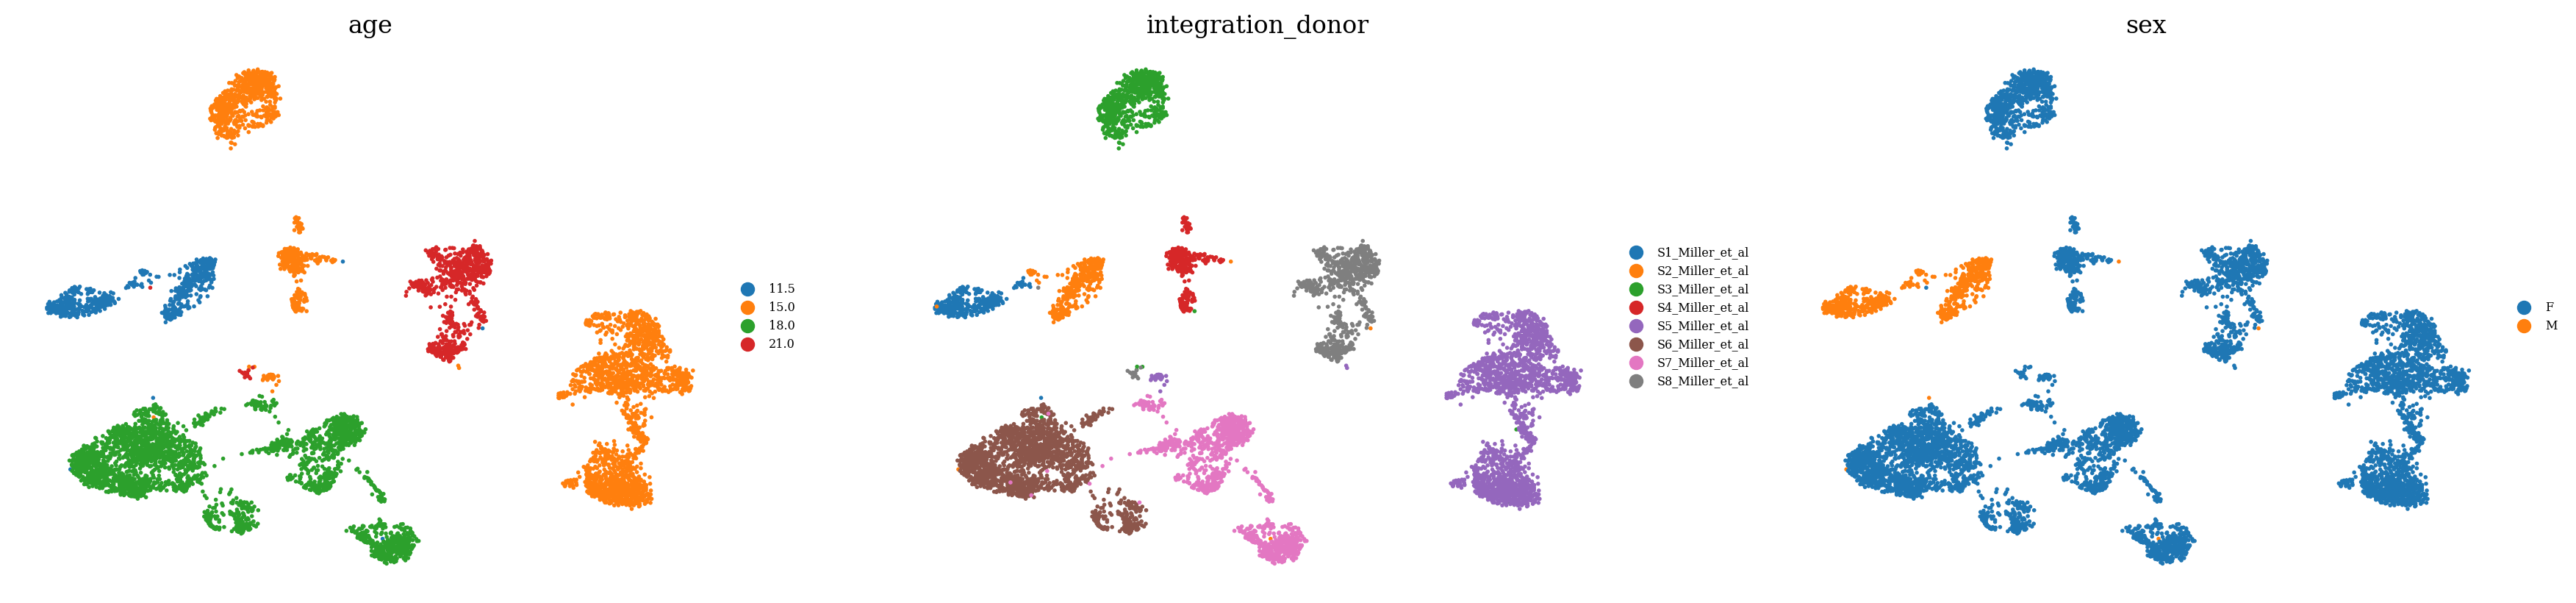

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

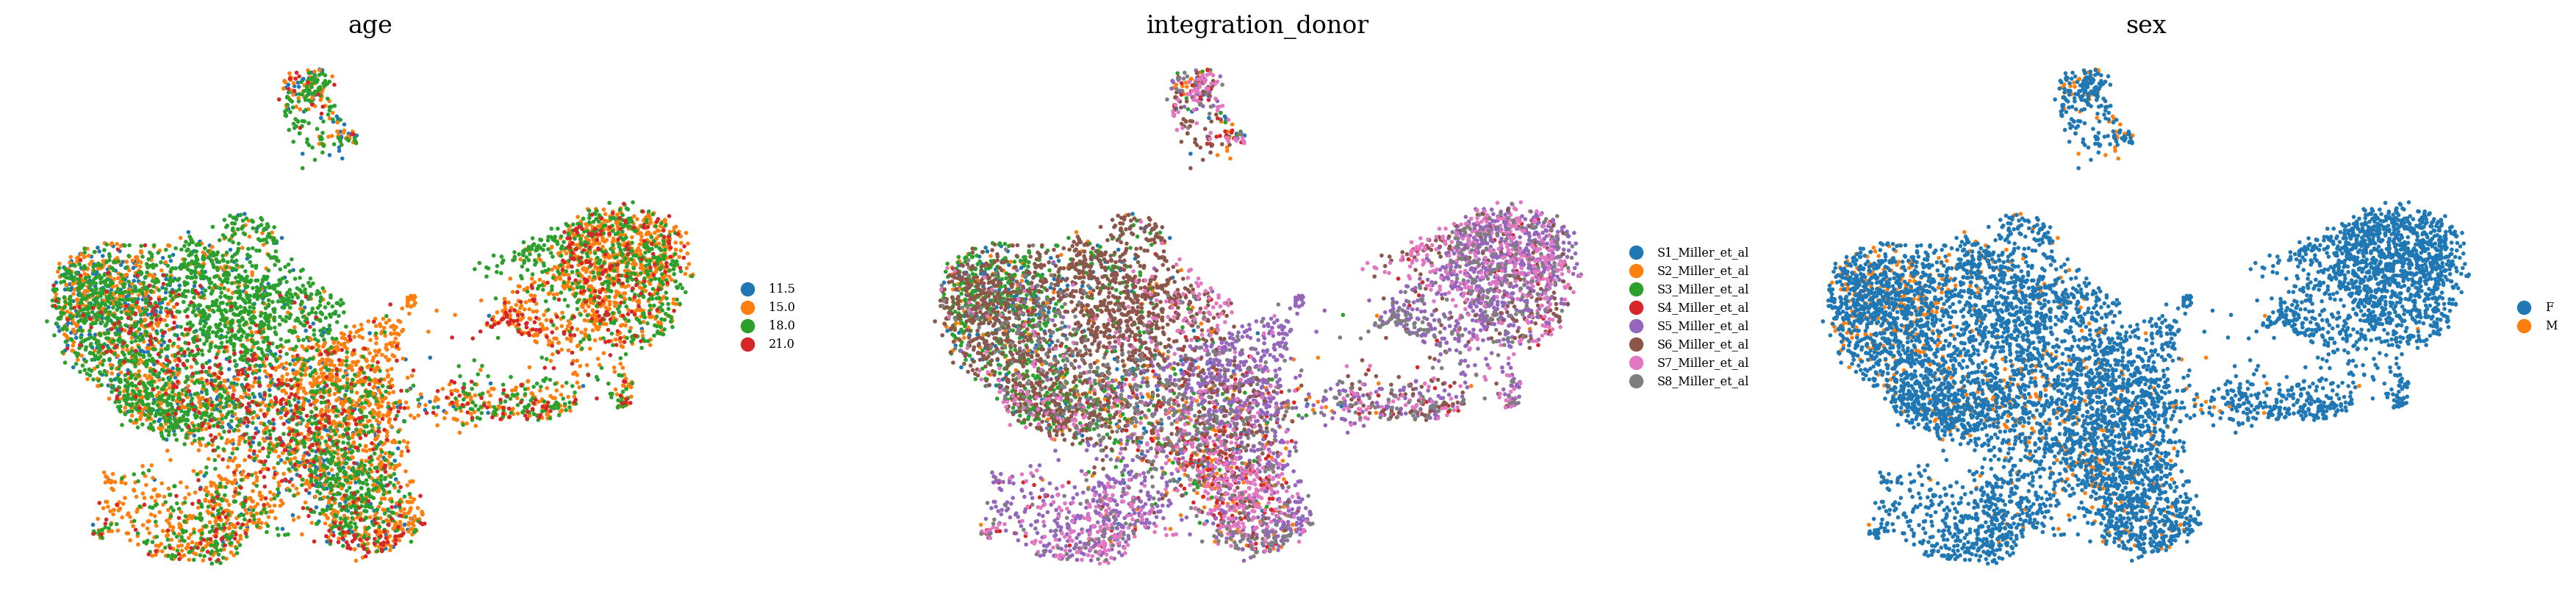

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  8%|▊         | 18/232 [00:00<00:01, 173.76it/s]

 16%|█▌        | 36/232 [00:00<00:01, 155.40it/s]

 22%|██▏       | 52/232 [00:00<00:01, 139.18it/s]

 29%|██▉       | 67/232 [00:00<00:01, 132.86it/s]

 35%|███▍      | 81/232 [00:00<00:01, 129.56it/s]

 41%|████      | 95/232 [00:00<00:01, 127.53it/s]

 47%|████▋     | 108/232 [00:00<00:00, 125.93it/s]

 52%|█████▏    | 121/232 [00:00<00:00, 123.62it/s]

 58%|█████▊    | 134/232 [00:01<00:00, 123.23it/s]

 63%|██████▎   | 147/232 [00:01<00:00, 123.29it/s]

 69%|██████▉   | 160/232 [00:01<00:00, 121.39it/s]

 75%|███████▍  | 173/232 [00:01<00:00, 121.56it/s]

 80%|████████  | 186/232 [00:01<00:00, 122.24it/s]

 86%|████████▌ | 199/232 [00:01<00:00, 122.56it/s]

 91%|█████████▏| 212/232 [00:01<00:00, 122.16it/s]

 97%|█████████▋| 225/232 [00:01<00:00, 121.81it/s]

100%|██████████| 232/232 [00:01<00:00, 126.61it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.5180913130951547

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)